WALMART DATA PIPELINE AND ANALYSIS PROJECT

In [5]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import calendar

from scipy import stats

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from category_encoders import BinaryEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


import warnings
warnings.filterwarnings('ignore')

plt.style.use(style='fivethirtyeight')
%matplotlib inline


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [7]:
data = pd.read_csv(r'C:\Users\Dell\Downloads\Walmart.csv')

In [8]:
data.head()

Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106

In [9]:
# some information about data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [10]:
# change float format in data
pd.options.display.float_format = '{:,.0f}'.format

In [11]:
# data distribution
data.describe().round(2)

Store  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price   CPI  \
count  6,435         6,435         6,435        6,435       6,435 6,435   
mean      23     1,046,965             0           61           3   172   
std       13       564,367             0           18           0    39   
min        1       209,986             0           -2           2   126   
25%       12       553,350             0           47           3   132   
50%       23       960,746             0           63           3   183   
75%       34     1,420,159             0           75           4   213   
max       45     3,818,686             1          100           4   227   

       Unemployment  
count         6,435  
mean              8  
std               2  
min               4  
25%               7  
50%               8  
75%               9  
max              14

In [12]:
# rename columns
data.columns  = data.columns.str.lower()
data.rename({'holiday_flag': 'is_holiday'}, axis = 1, inplace = True)
data.columns

Index(['store', 'date', 'weekly_sales', 'is_holiday', 'temperature',
       'fuel_price', 'cpi', 'unemployment'],
      dtype='object')

In [13]:
# check missing values
data.isnull().sum()

store           0
date            0
weekly_sales    0
is_holiday      0
temperature     0
fuel_price      0
cpi             0
unemployment    0
dtype: int64

In [14]:
# Check Duplicate Values
data.duplicated().sum()

0

In [15]:
def get_season(quarter):

    '''this function is to get season according to quarter column'''

    if quarter == 1:
        return 'Winter'
    elif quarter == 2:
        return 'Spring'
    elif quarter == 3:
        return 'Summer'
    else:
        return 'Autumn'

In [16]:
# correct data format of the 'date' column
data['date'] = pd.to_datetime(data['date'], format = "%d-%m-%Y")

# Create a new column "year" containing the year
data['year'] = data['date'].dt.year

# Create a new column "quarter" containing the season number
data['quarter'] = data['date'].dt.quarter

# Create a new column "season" containing the season
data['season'] = data['quarter'].apply(get_season)

# Create a new column "month" containing the month number
data['month'] = data['date'].dt.month

# Create a new column "month_name" containing the month names
data['month_name'] = data['date'].dt.month_name()

# Create a new column "week" containing the week number
data['week'] = data['date'].dt.isocalendar().week

# Create a new column "day_of_week" containing the day names
data['day_of_week'] = data['date'].dt.day_name()

In [17]:
# display a data sample
data.head(5)

store       date  weekly_sales  is_holiday  temperature  fuel_price  cpi  \
0      1 2010-02-05     1,643,691           0           42           3  211   
1      1 2010-02-12     1,641,957           1           39           3  211   
2      1 2010-02-19     1,611,968           0           40           3  211   
3      1 2010-02-26     1,409,728           0           47           3  211   
4      1 2010-03-05     1,554,807           0           46           3  211   

   unemployment  year  quarter  season  month month_name  week day_of_week  
0             8  2010        1  Winter      2   February     5      Friday  
1             8  2010        1  Winter      2   February     6      Friday  
2             8  2010        1  Winter      2   February     7      Friday  
3             8  2010        1  Winter      2   February     8      Friday  
4             8  2010        1  Winter      3      March     9      Friday

In [18]:
data['week'] = data['week'].astype('int32')

In [19]:
data[['weekly_sales', 'temperature', 'fuel_price', 'unemployment', 'cpi']].describe()

weekly_sales  temperature  fuel_price  unemployment   cpi
count         6,435        6,435       6,435         6,435 6,435
mean      1,046,965           61           3             8   172
std         564,367           18           0             2    39
min         209,986           -2           2             4   126
25%         553,350           47           3             7   132
50%         960,746           63           3             8   183
75%       1,420,159           75           4             9   213
max       3,818,686          100           4            14   227

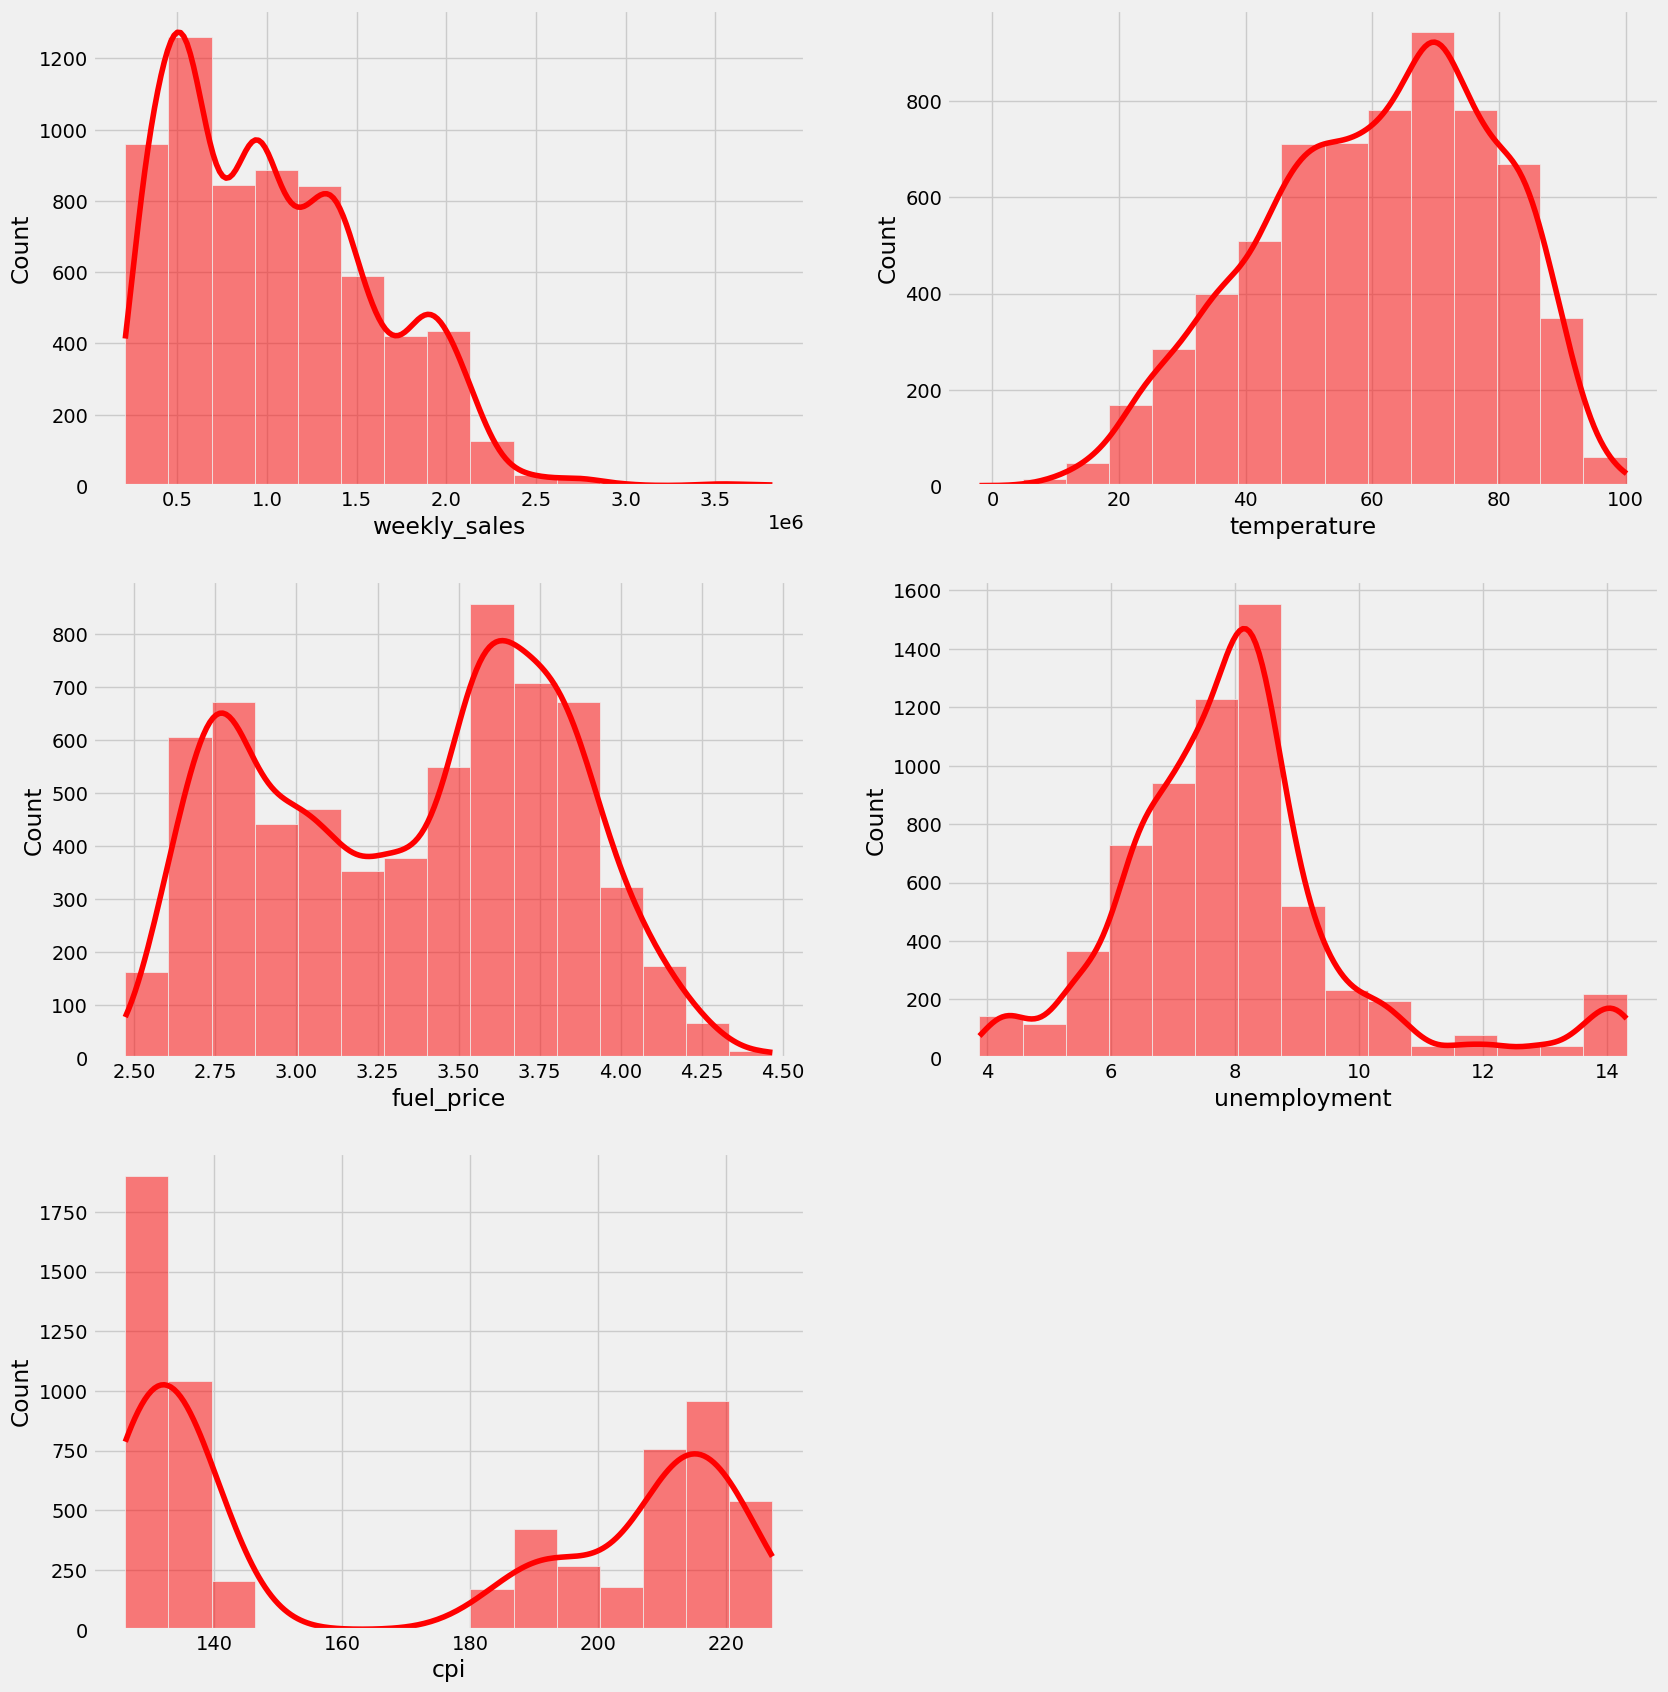

In [20]:
columns = ['weekly_sales', 'temperature', 'fuel_price', 'unemployment', 'cpi']
plt.figure(figsize=(18, 20))
for i,col in enumerate(columns):
    plt.subplot(3, 2, i+1)
    sns.histplot(data = data, x = col, kde = True, bins = 15, color = 'r')
plt.show()

In [21]:
d = data['is_holiday'].value_counts()
d

is_holiday
0    5985
1     450
Name: count, dtype: int64

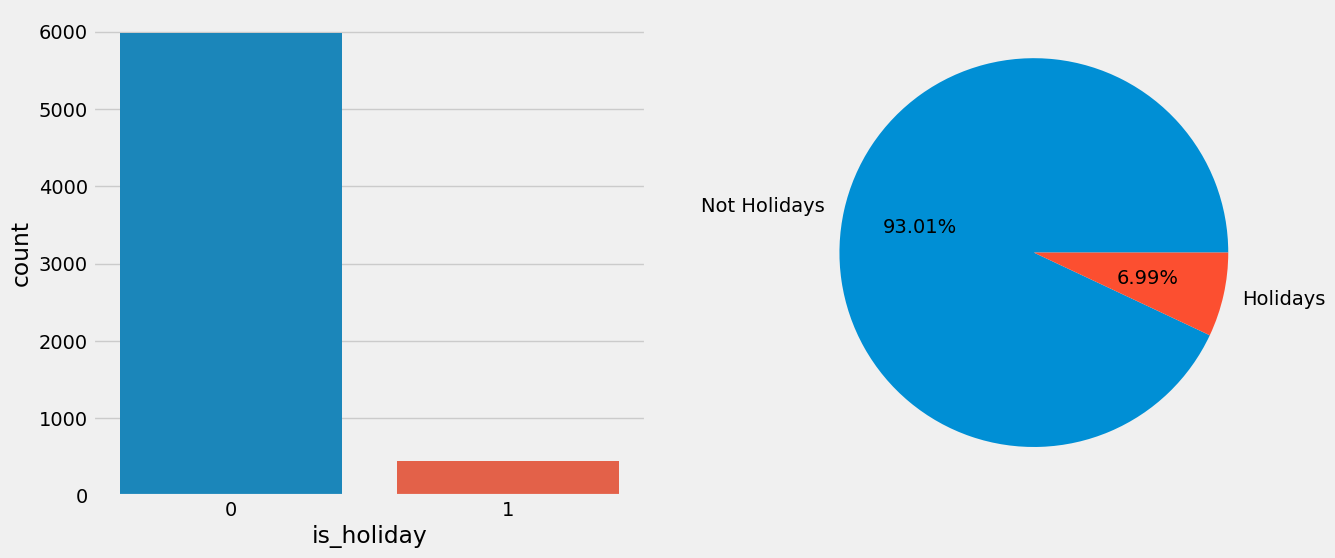

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
sns.countplot(data = data, x = 'is_holiday', ax = ax[0])

ax[1].pie(data['is_holiday'].value_counts().values,
          labels = ['Not Holidays', 'Holidays'],
          autopct = '%1.2f%%')

plt.show()

In [23]:
data['year'].value_counts()

year
2011    2340
2010    2160
2012    1935
Name: count, dtype: int64

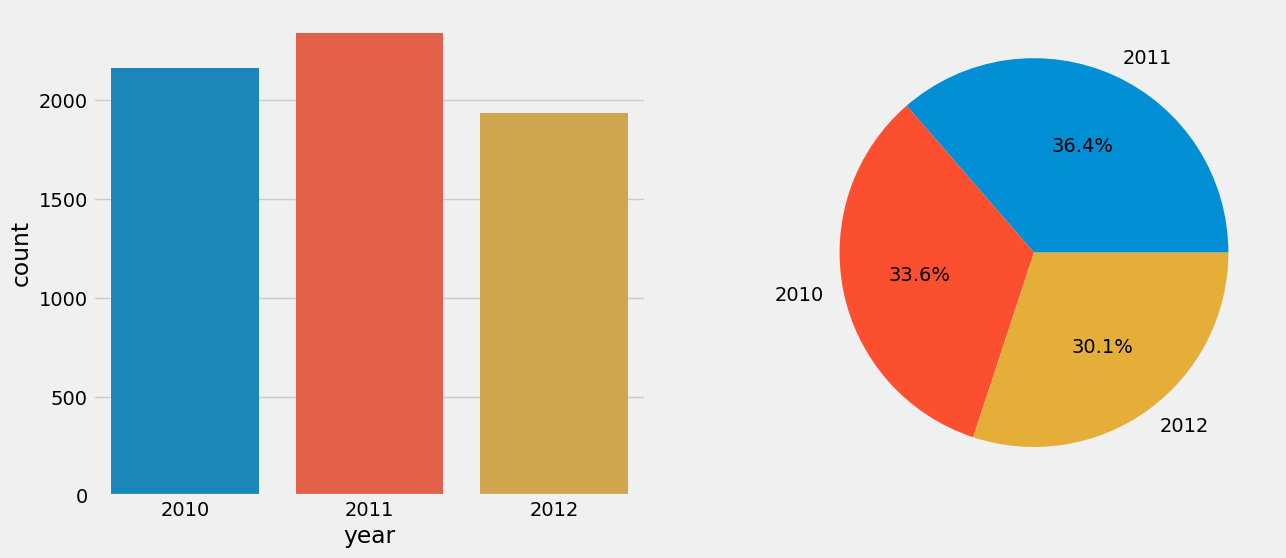

In [24]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
sns.countplot(data = data, x = 'year', ax = ax[0])
ax[1].pie(data['year'].value_counts().values,
          labels = data['year'].value_counts().index,
          autopct = '%1.1f%%')
plt.show()


In [25]:
data['season'].value_counts()

season
Summer    1800
Spring    1755
Winter    1485
Autumn    1395
Name: count, dtype: int64

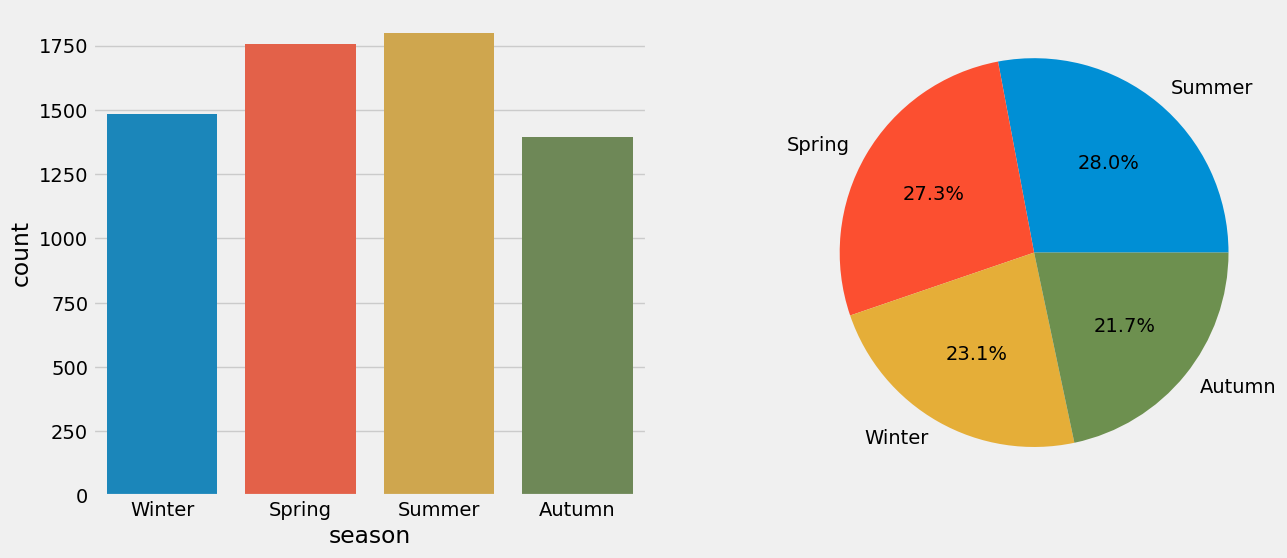

In [26]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))
sns.countplot(data = data, x = 'season', ax = ax[0])
ax[1].pie(data['season'].value_counts().values,
          labels = data['season'].value_counts().index,
          autopct = '%1.1f%%')
plt.show()

In [27]:
data['month_name'].value_counts()

month_name
April        630
July         630
March        585
June         585
August       585
September    585
October      585
February     540
May          540
December     450
November     360
January      360
Name: count, dtype: int64

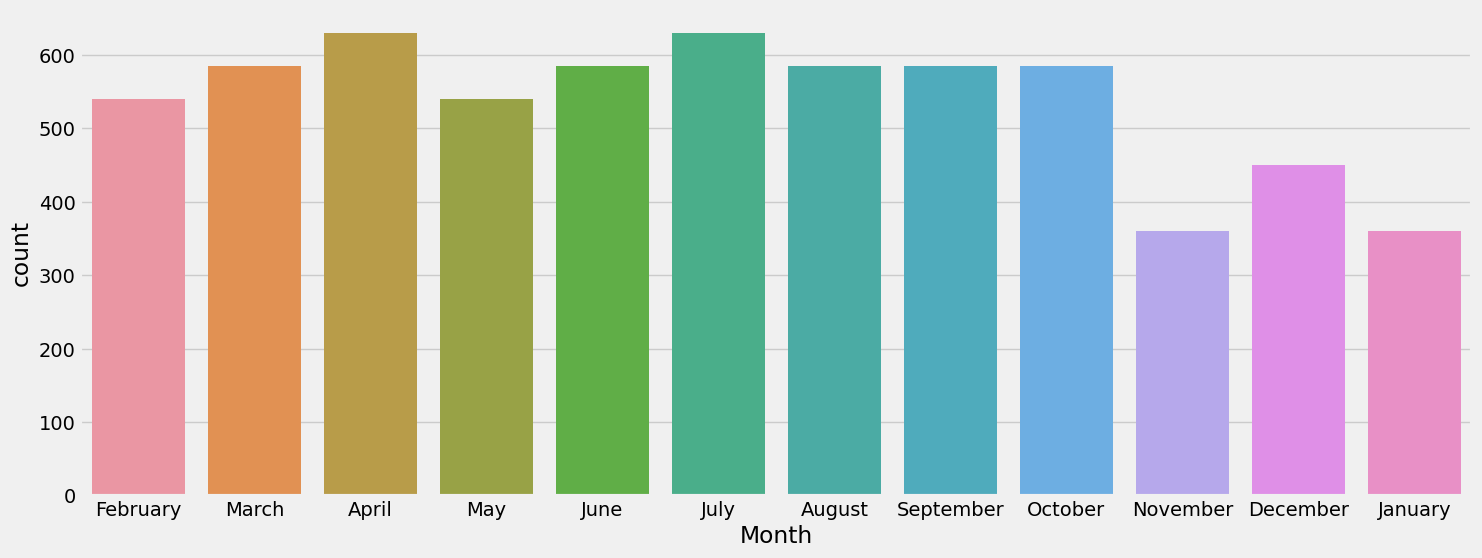

In [28]:
plt.figure(figsize=(16, 6))
sns.countplot(data = data, x = 'month_name')
plt.xlabel('Month')
plt.show()

In [29]:
data['day_of_week'].value_counts()

day_of_week
Friday    6435
Name: count, dtype: int64

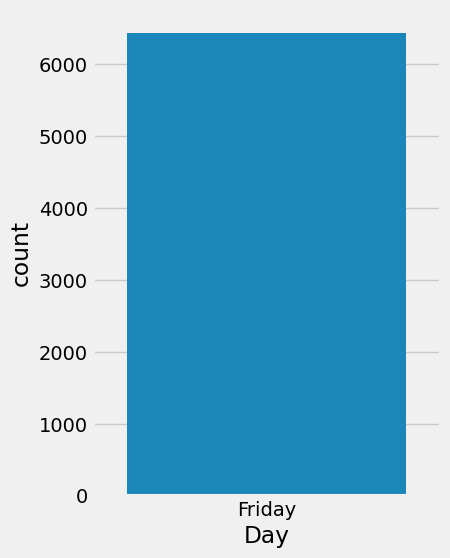

In [30]:
plt.figure(figsize=(4, 6))
sns.countplot(data = data, x = 'day_of_week')
plt.xlabel('Day')
plt.show()


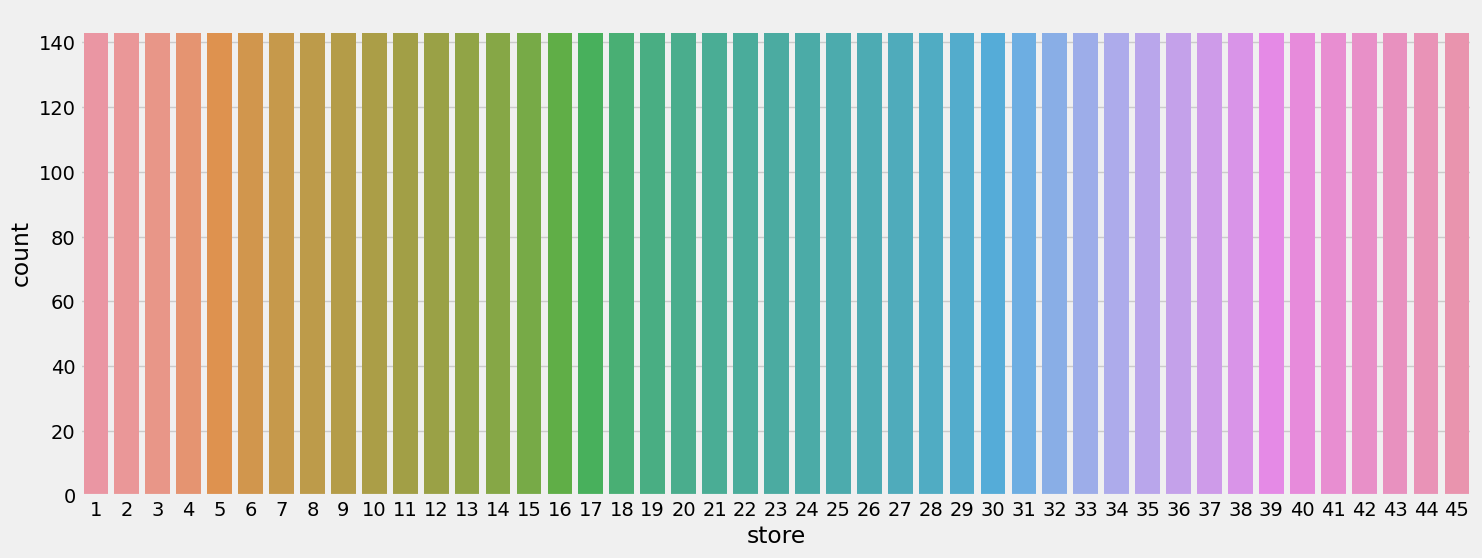

In [31]:
plt.figure(figsize=(16, 6))
sns.countplot(data = data, x = 'store')
plt.show()

In [32]:
data.groupby('is_holiday')['weekly_sales'].mean()

is_holiday
0   1,041,256
1   1,122,888
Name: weekly_sales, dtype: float64

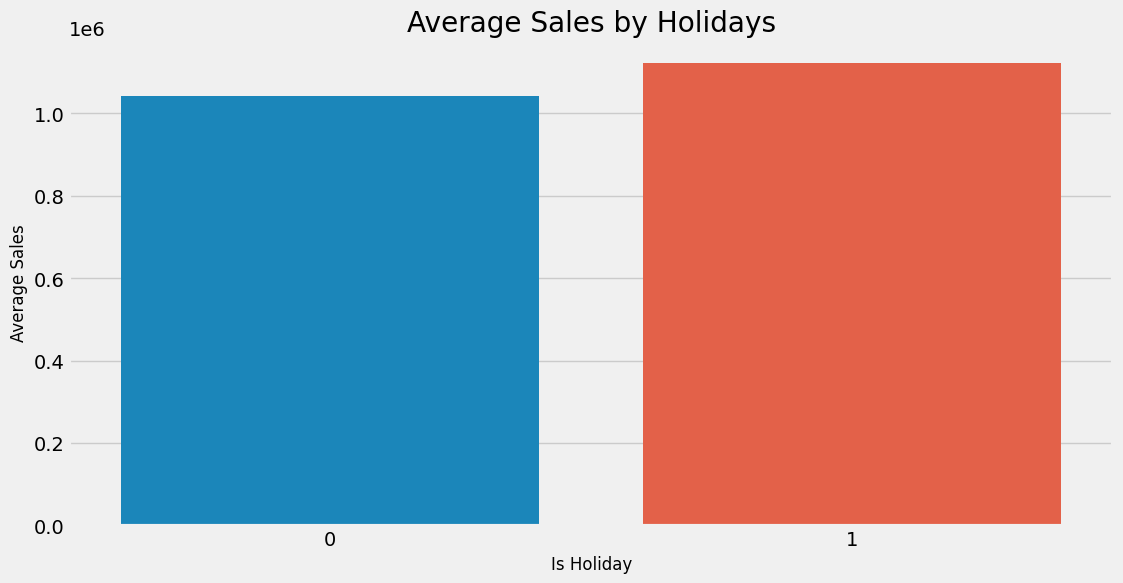

In [33]:
plt.figure(figsize = (12, 6))
sns.barplot(data = data,
            x = 'is_holiday',
            y = 'weekly_sales',
            estimator = np.mean,
            ci = False)

# Add labels and title
plt.title('Average Sales by Holidays')
plt.xlabel('Is Holiday', size = 12)
plt.ylabel('Average Sales', size = 12)
plt.show()

In [34]:
data.groupby('is_holiday')['weekly_sales'].sum()

is_holiday
0   6,231,919,436
1     505,299,552
Name: weekly_sales, dtype: float64

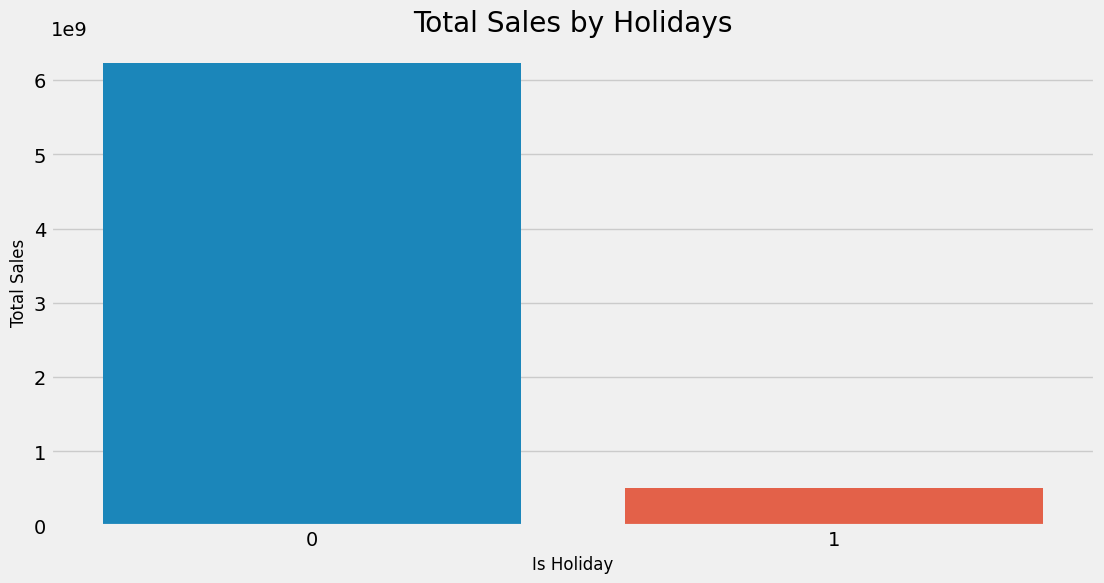

In [35]:
plt.figure(figsize = (12, 6))
sns.barplot(data = data,
            x = 'is_holiday',
            y = 'weekly_sales',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total Sales by Holidays')
plt.xlabel('Is Holiday', size = 12)
plt.ylabel('Total Sales', size = 12)
plt.show()

In [36]:
gb_store = data.groupby('store')['weekly_sales'].sum().sort_values(ascending = False)
gb_store

store
20   301,397,792
4    299,543,953
14   288,999,911
13   286,517,704
2    275,382,441
10   271,617,714
27   253,855,917
6    223,756,131
1    222,402,809
39   207,445,542
19   206,634,862
31   199,613,906
23   198,750,618
24   194,016,021
11   193,962,787
28   189,263,681
41   181,341,935
32   166,819,246
18   155,114,734
22   147,075,649
12   144,287,230
26   143,416,394
34   138,249,763
40   137,870,310
35   131,520,672
8    129,951,181
17   127,782,139
45   112,395,341
21   108,117,879
25   101,061,179
43    90,565,435
15    89,133,684
7     81,598,275
42    79,565,752
9     77,789,219
29    77,141,554
16    74,252,425
37    74,202,740
30    62,716,885
3     57,586,735
38    55,159,626
36    53,412,215
5     45,475,689
44    43,293,088
33    37,160,222
Name: weekly_sales, dtype: float64

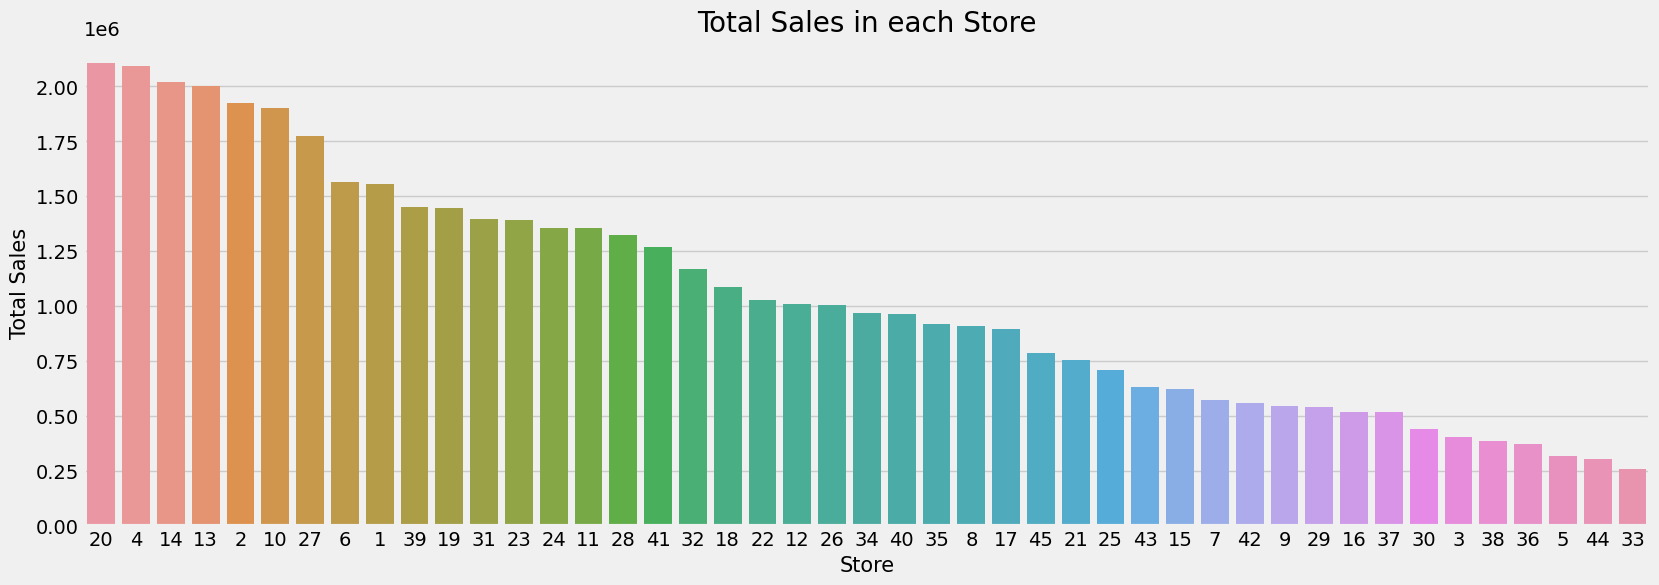

In [37]:
plt.figure(figsize = (18, 6))
sns.barplot(data = data,
            x = 'store',
            y = 'weekly_sales',
            order = gb_store.index,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Store', size = 20)
plt.xlabel('Store', size = 15)
plt.ylabel('Total Sales', size = 15)
plt.show()

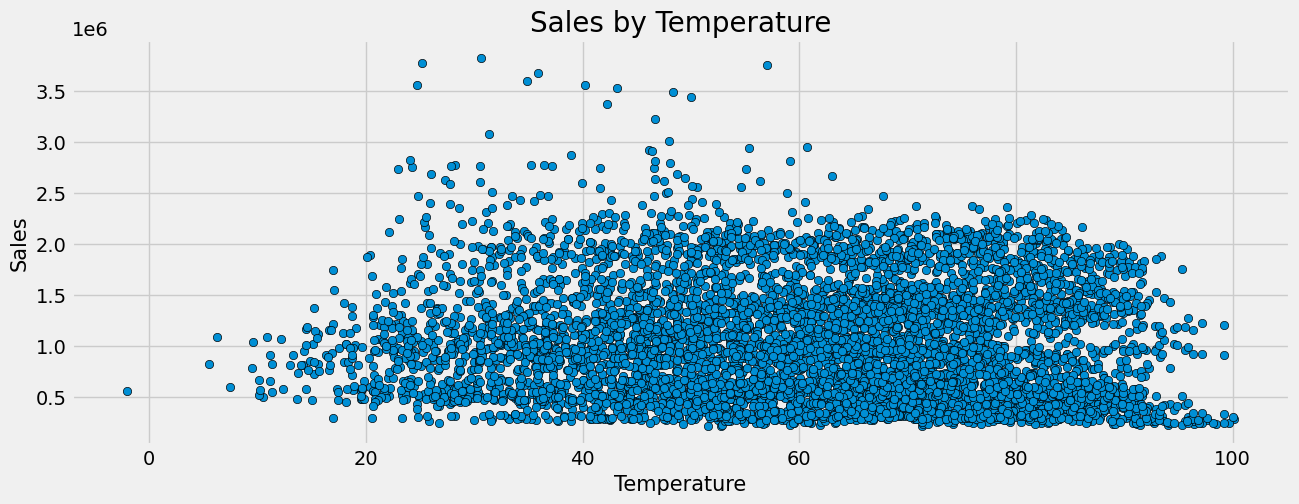

In [38]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = data,
                x = 'temperature',
                y = 'weekly_sales',
                edgecolor = "black")

# Add labels and title
plt.title('Sales by Temperature', size = 20)
plt.xlabel('Temperature', size = 15)
plt.ylabel('Sales', size = 15)
plt.show()

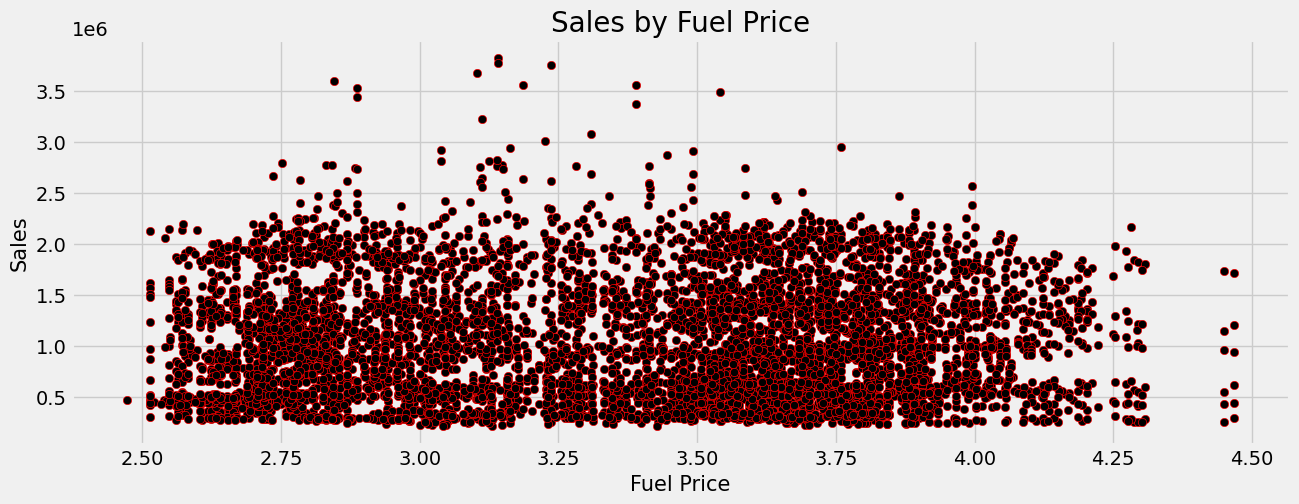

In [39]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = data,
                x = 'fuel_price',
                y = 'weekly_sales',
                color = 'black',
                edgecolor = "red")

# Add labels and title
plt.title('Sales by Fuel Price', size = 20)
plt.xlabel('Fuel Price', size = 15)
plt.ylabel('Sales', size = 15)
plt.show()


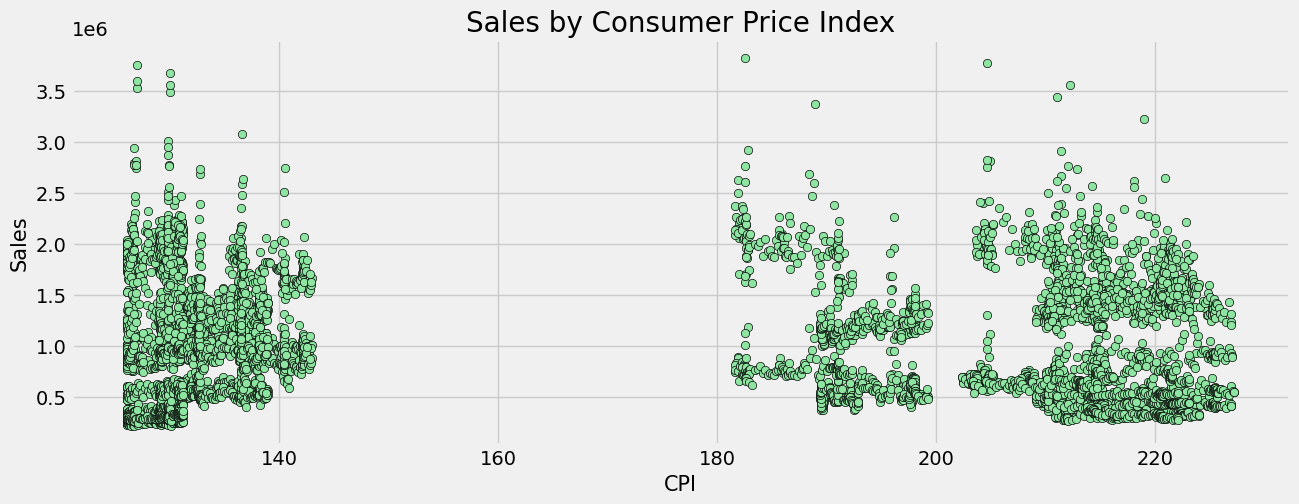

In [40]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = data,
                x = 'cpi',
                y = 'weekly_sales',
                color = '#8de5a1',
                edgecolor = "black")

# Add labels and title
plt.title('Sales by Consumer Price Index', size = 20)
plt.xlabel('CPI', size = 15)
plt.ylabel('Sales', size = 15)
plt.show()

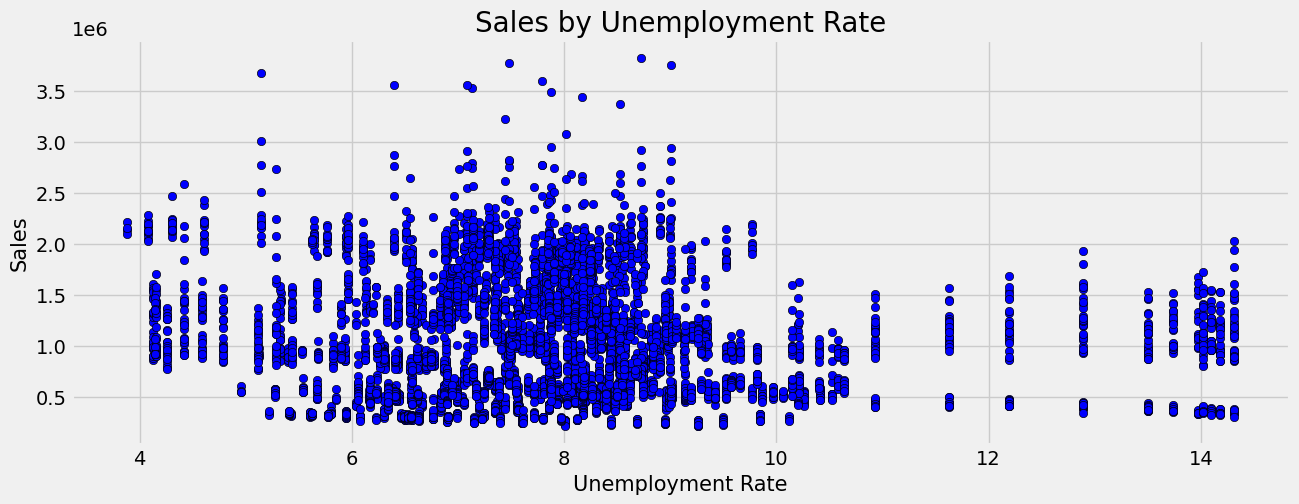

In [41]:
plt.figure(figsize = (14, 5))
sns.scatterplot(data = data,
                x = 'unemployment',
                y = 'weekly_sales',
                color = 'blue',
                edgecolor = 'black')

# Add labels and title
plt.title('Sales by Unemployment Rate', size = 20)
plt.xlabel('Unemployment Rate', size = 15)
plt.ylabel('Sales', size = 15)
plt.show()

In [42]:
data.groupby('year')['weekly_sales'].sum().sort_values(ascending = False)

year
2011   2,448,200,007
2010   2,288,886,120
2012   2,000,132,859
Name: weekly_sales, dtype: float64

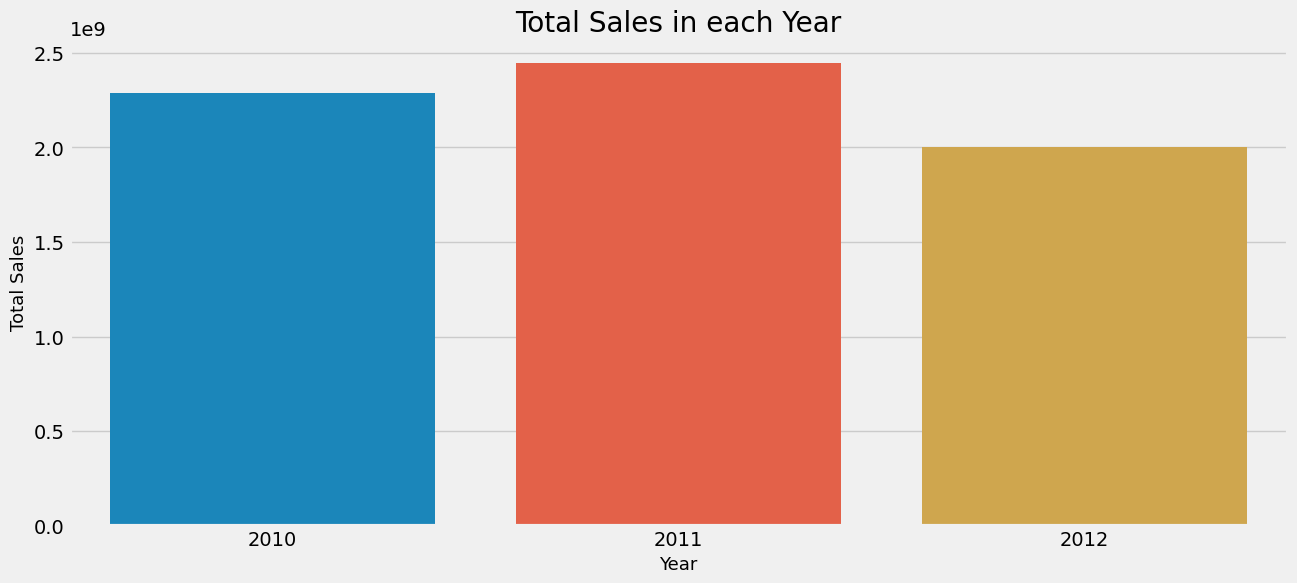

In [43]:
plt.figure(figsize = (14, 6))
sns.barplot(data = data,
            x = 'year',
            y = 'weekly_sales',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Year')
plt.xlabel('Year', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()

In [44]:
data.groupby('season')['weekly_sales'].sum().sort_values(ascending = False)

season
Summer   1,841,852,365
Spring   1,826,615,244
Autumn   1,574,639,148
Winter   1,494,112,230
Name: weekly_sales, dtype: float64

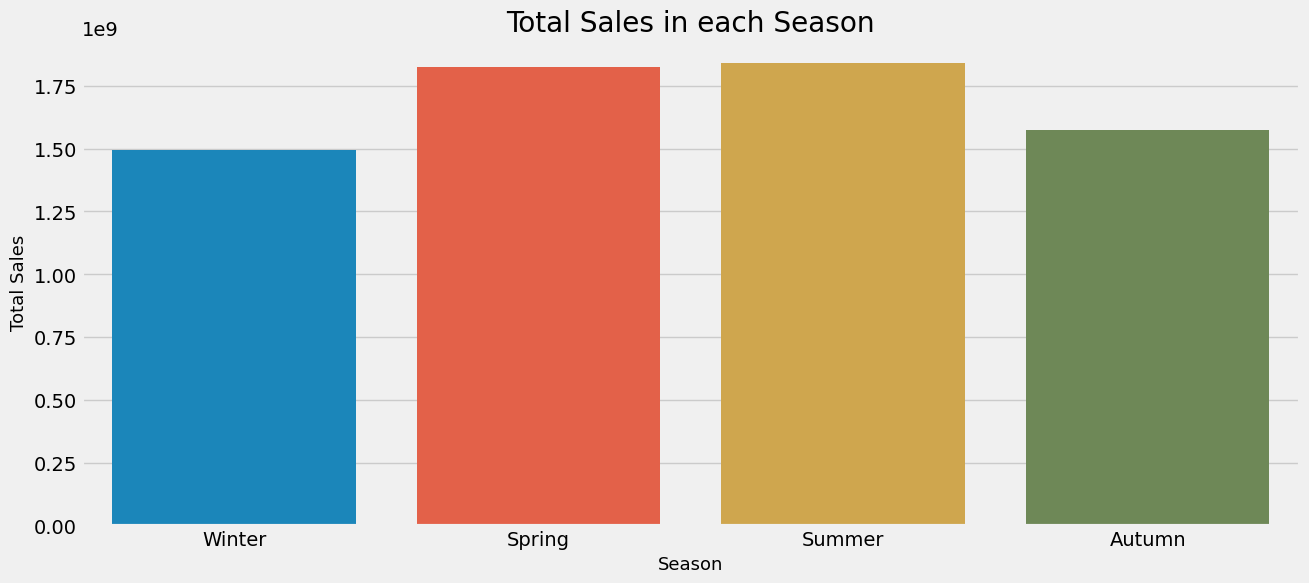

In [45]:
plt.figure(figsize = (14, 6))
sns.barplot(data = data,
            x = 'season',
            y = 'weekly_sales',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Season')
plt.xlabel('Season', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()

In [46]:
data.groupby('month_name')['weekly_sales'].sum().sort_values(ascending = False)

month_name
July        650,000,977
April       646,859,785
June        622,629,887
August      613,090,209
March       592,785,901
October     584,784,788
September   578,761,179
December    576,838,635
February    568,727,890
May         557,125,572
November    413,015,725
January     332,598,438
Name: weekly_sales, dtype: float64

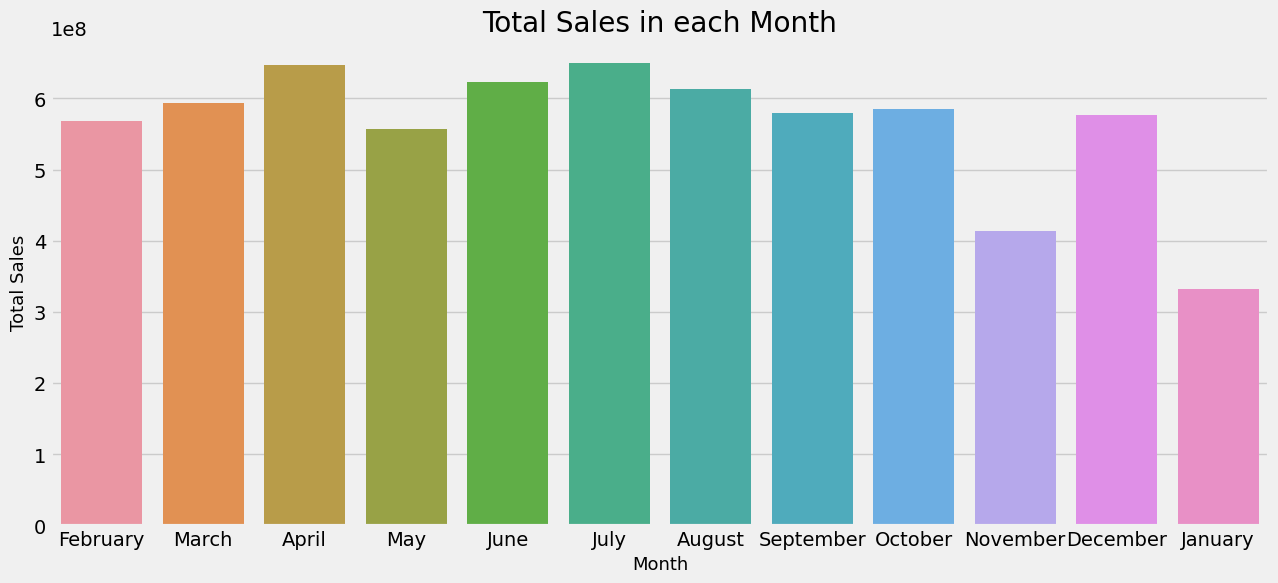

In [47]:
plt.figure(figsize = (14, 6))
sns.barplot(data = data,
            x = 'month_name',
            y = 'weekly_sales',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Month')
plt.xlabel('Month', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()

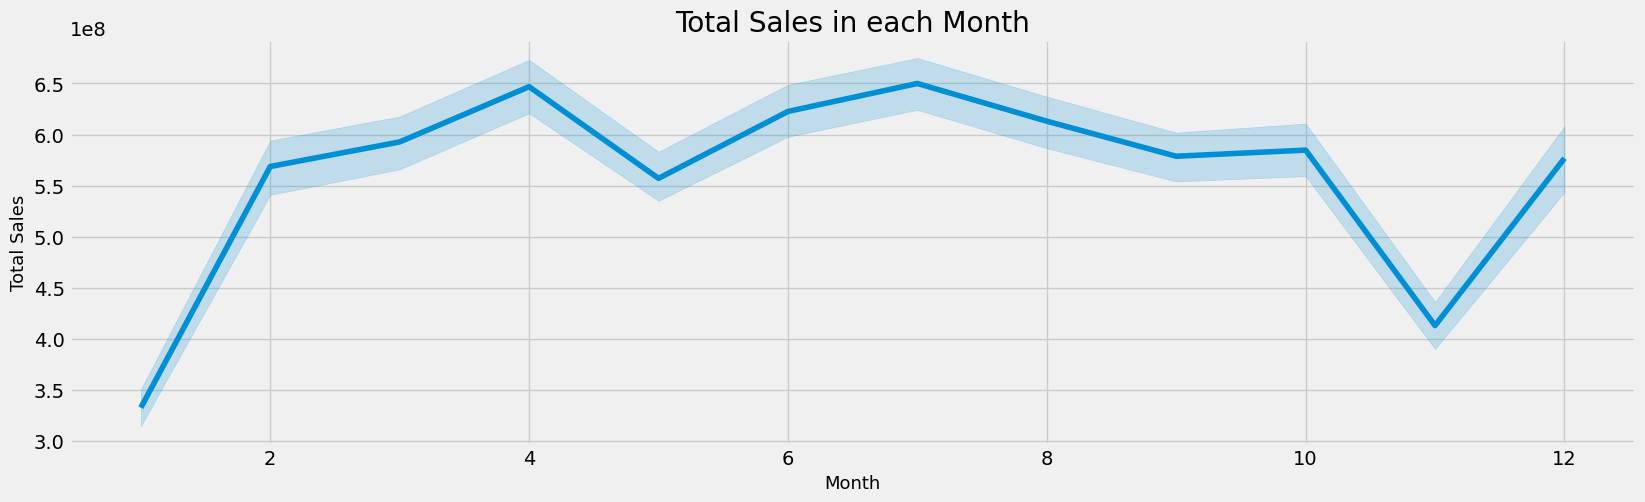

In [48]:
plt.figure(figsize = (18, 5))
sns.lineplot(data = data,
            x = 'month',
            y = 'weekly_sales',
            estimator = np.sum)

# Add labels and title
plt.title('Total Sales in each Month')
plt.xlabel('Month', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()

In [49]:
gp_week = data.groupby('week')['weekly_sales'].sum().sort_values(ascending = False)
gp_week

week
51   157,929,657
22   147,242,187
7    147,190,215
27   147,011,815
14   146,755,073
6    145,682,278
23   145,147,453
31   143,706,366
24   143,481,719
26   143,093,116
18   142,489,400
5    141,989,460
33   141,332,753
21   140,943,423
34   140,774,012
36   140,727,685
9    140,713,109
25   140,161,416
32   140,117,439
40   139,881,302
35   139,730,520
13   139,155,684
16   138,483,674
10   138,033,170
28   137,859,562
19   137,702,104
15   136,786,257
11   136,762,806
29   136,222,804
20   135,990,645
43   135,002,768
42   134,008,034
8    133,865,938
41   133,652,808
47   132,414,608
30   132,410,793
12   132,003,955
37   131,100,725
17   130,951,958
38   128,431,158
39   128,170,606
50   121,906,496
49   111,227,918
48    99,299,584
45    94,599,026
44    94,437,526
46    91,564,565
1     87,731,210
52    86,474,980
3     82,735,645
2     82,696,757
4     79,434,828
Name: weekly_sales, dtype: float64

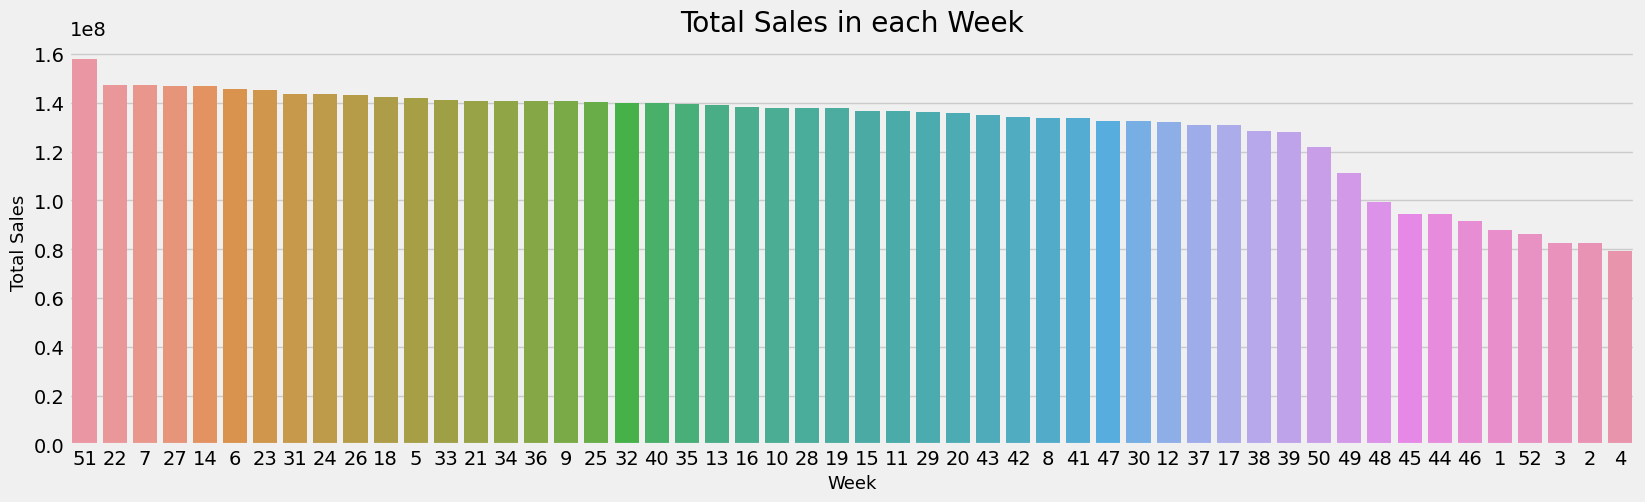

In [50]:
plt.figure(figsize = (18, 5))
sns.barplot(data = data,
            x = 'week',
            y = 'weekly_sales',
            estimator = np.sum,
            order = gp_week.index,
            ci = False)

# Add labels and title
plt.title('Total Sales in each Week')
plt.xlabel('Week', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()

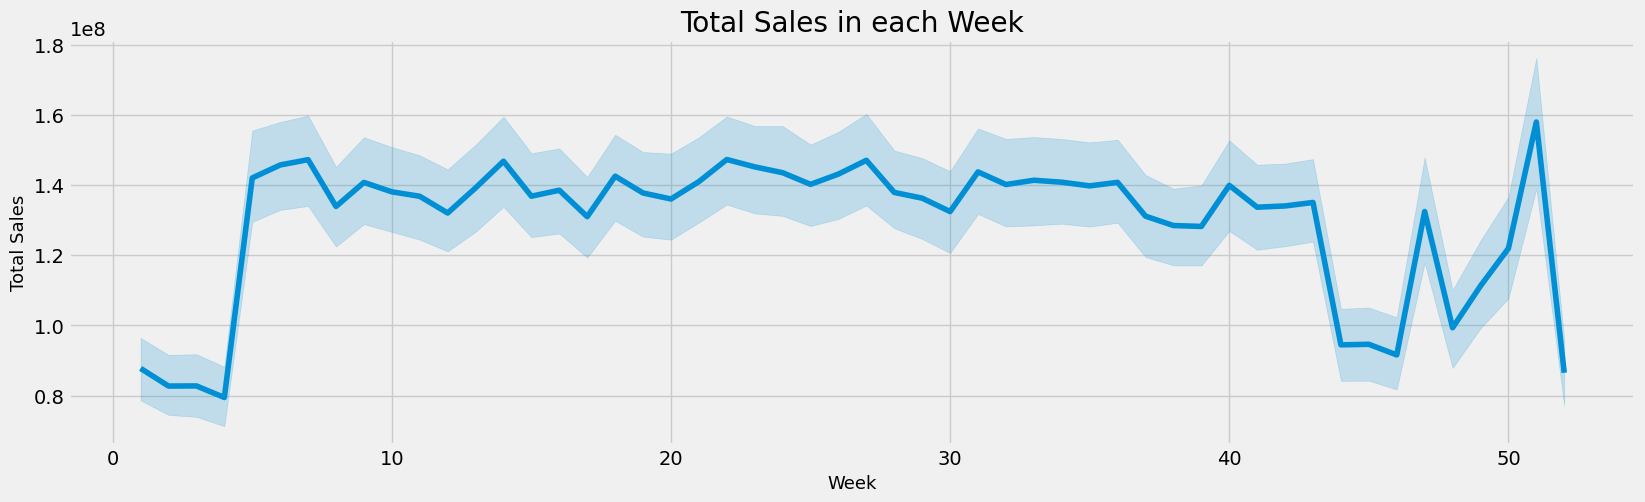

In [51]:
plt.figure(figsize = (18, 5))
sns.lineplot(data = data,
            x = 'week',
            y = 'weekly_sales',
            estimator = np.sum)

# Add labels and title
plt.title('Total Sales in each Week')
plt.xlabel('Week', size = 13)
plt.ylabel('Total Sales', size = 13)
plt.show()


In [52]:
pd.pivot_table(data = data,
               index = 'year',
               columns = 'month_name',
               values = 'weekly_sales',
               aggfunc = 'sum')

month_name       April      August    December    February     January  \
year                                                                     
2010       231,412,368 187,640,111 288,760,533 190,332,983         NaN   
2011       226,526,511 188,599,332 288,078,102 186,331,328 163,703,967   
2012       188,920,906 236,850,766         NaN 192,063,580 168,894,472   

month_name        July        June       March         May    November  \
year                                                                     
2010       232,580,126 192,246,172 181,919,802 186,710,934 202,853,370   
2011       229,911,399 189,773,385 179,356,448 181,648,158 210,162,355   
2012       187,509,452 240,610,329 231,509,650 188,766,479         NaN   

month_name     October   September  
year                                
2010       217,161,824 177,267,896  
2011       183,261,283 220,847,738  
2012       184,361,680 180,645,544

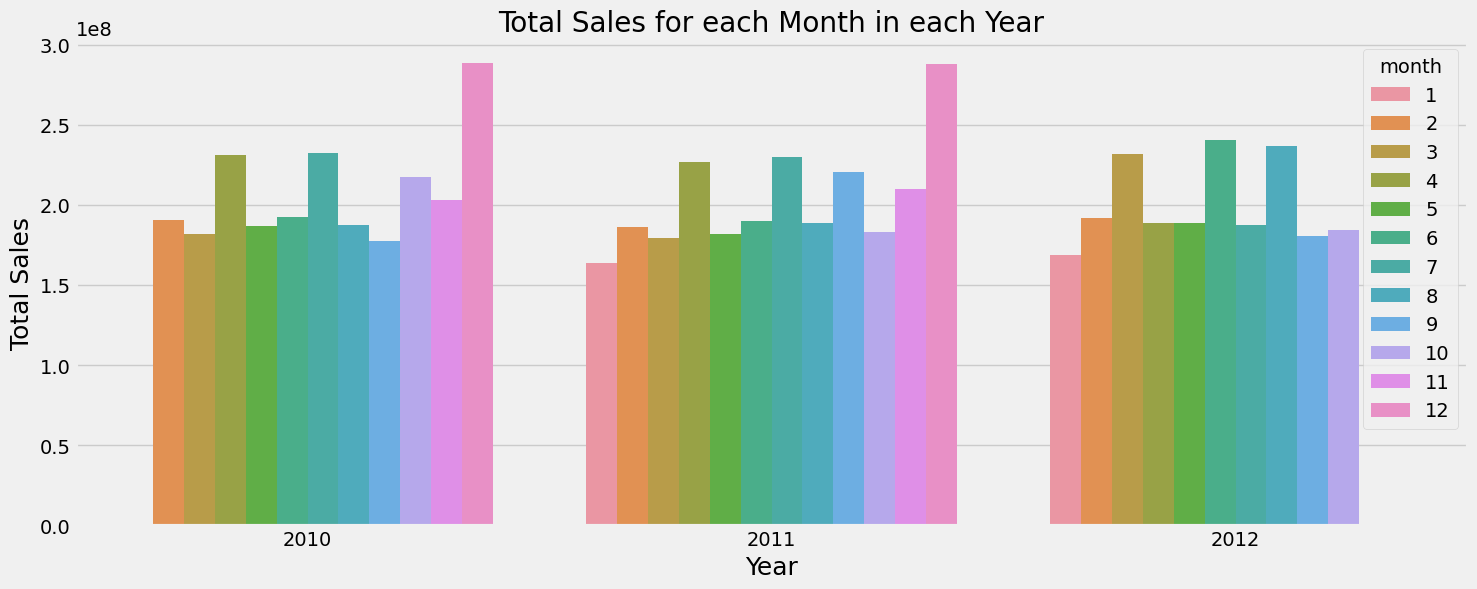

In [53]:
plt.figure(figsize = (16, 6))
sns.barplot(data = data,
            x = 'year',
            y = 'weekly_sales',
            hue = 'month',
            estimator = np.sum,
            ci = False)

# Add labels and title
plt.title('Total Sales for each Month in each Year')
plt.xlabel('Year', size = 18)
plt.ylabel('Total Sales', size = 18)

plt.show()


In [54]:
pd.pivot_table(data = data,
               index = 'year',
               columns = 'season',
               values = 'weekly_sales',
               aggfunc = 'sum')

season      Autumn      Spring      Summer      Winter
year                                                  
2010   708,775,727 610,369,475 597,488,133 372,252,786
2011   681,501,740 597,948,054 639,358,470 529,391,743
2012   184,361,680 618,297,715 605,005,763 592,467,702

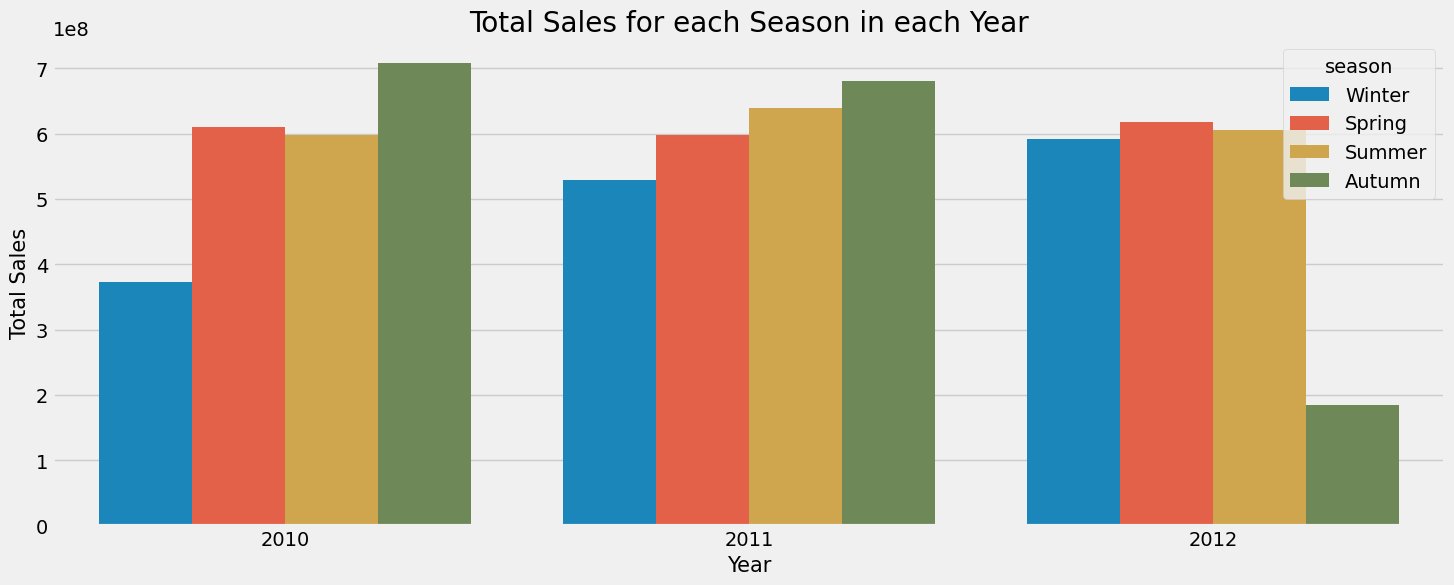

In [55]:
plt.figure(figsize = (16, 6))
sns.barplot(data = data,
            x = 'year',
            y = 'weekly_sales',
            hue = 'season',
            estimator = np.sum,
           ci = False)

# Add labels and title
plt.title('Total Sales for each Season in each Year')
plt.xlabel('Year', size = 15)
plt.ylabel('Total Sales', size = 15)
plt.show()

In [56]:
pd.pivot_table(data = data,
               index = 'year',
               columns = 'day_of_week',
               values = 'weekly_sales',
               aggfunc = 'sum')

day_of_week        Friday
year                     
2010        2,288,886,120
2011        2,448,200,007
2012        2,000,132,859

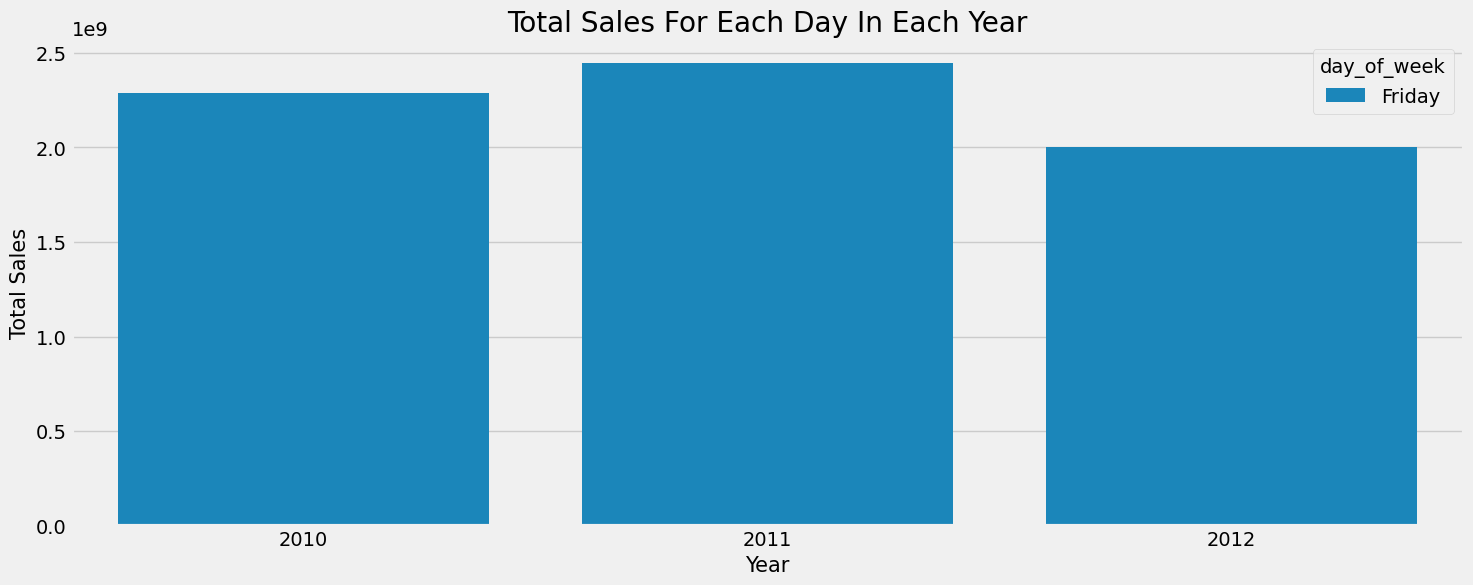

In [57]:
plt.figure(figsize = (16, 6))
sns.barplot(data = data,
            x = 'year',
            y = 'weekly_sales',
            hue = 'day_of_week',
            estimator = np.sum,
           ci = False)

# Add labels and title
plt.title('Total Sales For Each Day In Each Year')
plt.xlabel('Year', size = 15)
plt.ylabel('Total Sales', size = 15)
plt.show()


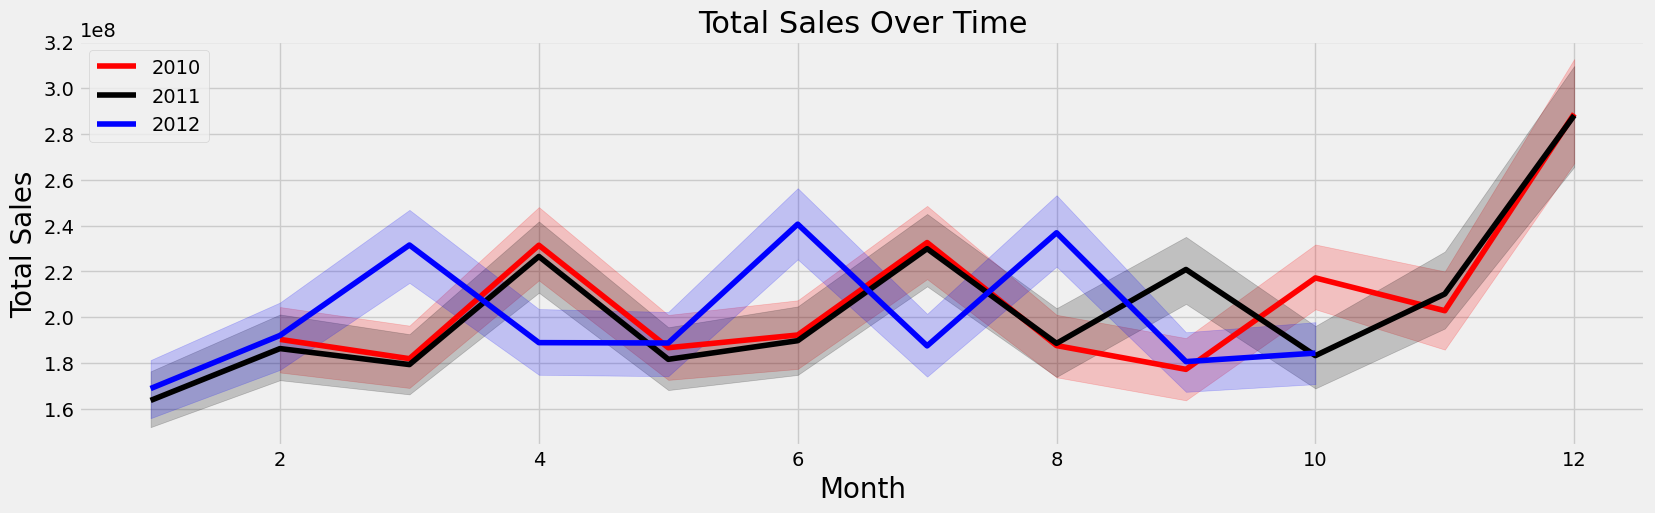

In [58]:
years = ['2010', '2011', '2012']
colors = ['red', 'black', 'blue']

plt.figure(figsize = (18, 5))
for i, year in enumerate(years):
    sns.lineplot(data = data[data['year'] == int(year)],
                 x = 'month',
                 y = 'weekly_sales',
                 estimator = np.sum,
                 color = colors[i],
                 label = year)

# Add labels and title
plt.title(f'Total Sales Over Time', size = 22)
plt.xlabel('Month', size = 20)
plt.ylabel('Total Sales', size = 20)

# Add a legend
plt.legend()

# Show the plot
plt.show()

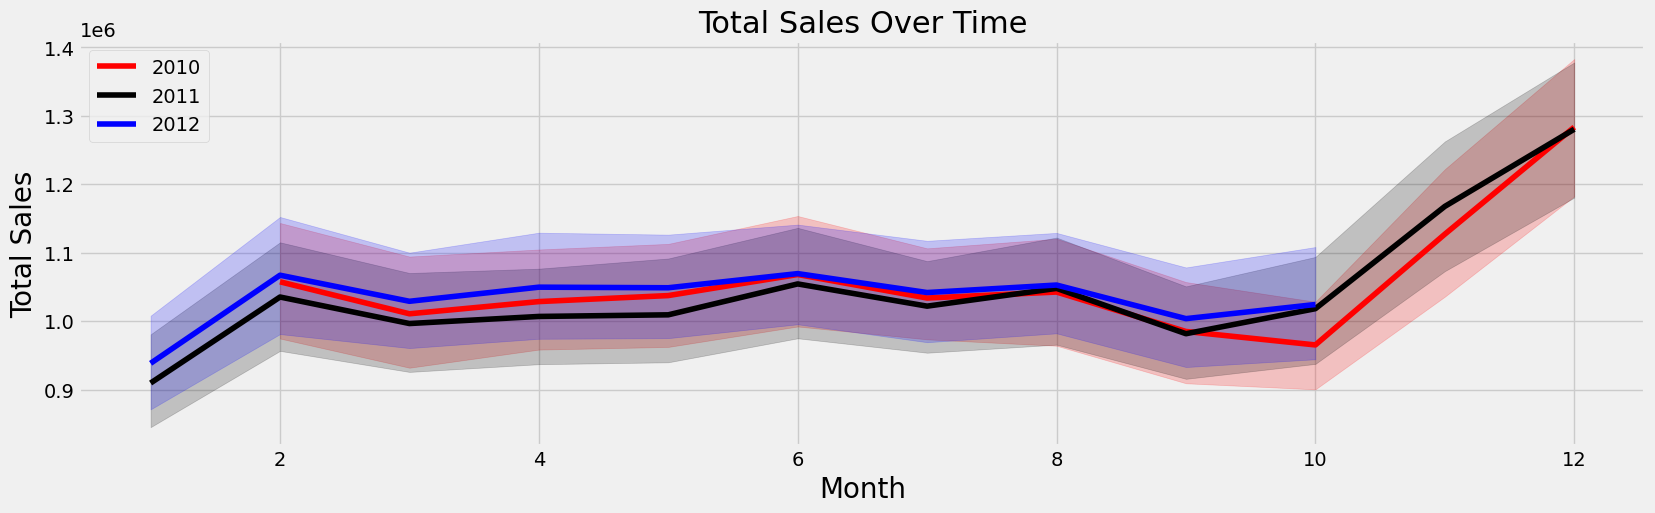

In [59]:
plt.figure(figsize = (18, 5))
for i, year in enumerate(years):
    sns.lineplot(data = data[data['year'] == int(year)],
                 x = 'month',
                 y = 'weekly_sales',
                 estimator = np.mean,
                 color = colors[i],
                 label = year)

# Add labels and title
plt.title(f'Total Sales Over Time', size = 22)
plt.xlabel('Month', size = 20)
plt.ylabel('Total Sales', size = 20)

# Add a legend
plt.legend()

# Show the plot
plt.show()

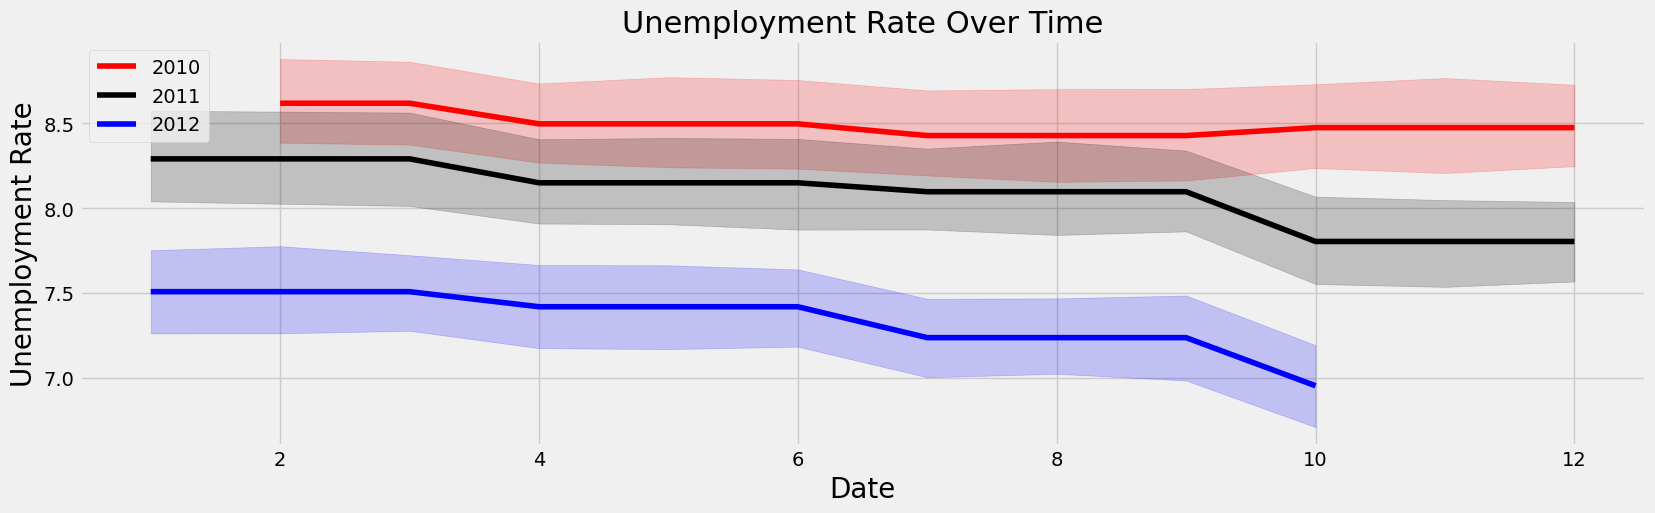

In [60]:
plt.figure(figsize = (18, 5))
for i, year in enumerate(years):
    sns.lineplot(data = data[data['year'] == int(year)],
                 x = 'month',
                 y = 'unemployment',
                 estimator = np.mean,
                 color = colors[i],
                 label = year)

# Add labels and title
plt.title(f'Unemployment Rate Over Time', size = 22)
plt.xlabel('Date', size = 20)
plt.ylabel('Unemployment Rate', size = 20)

# Add a legend
plt.legend()

# Show the plot
plt.show()

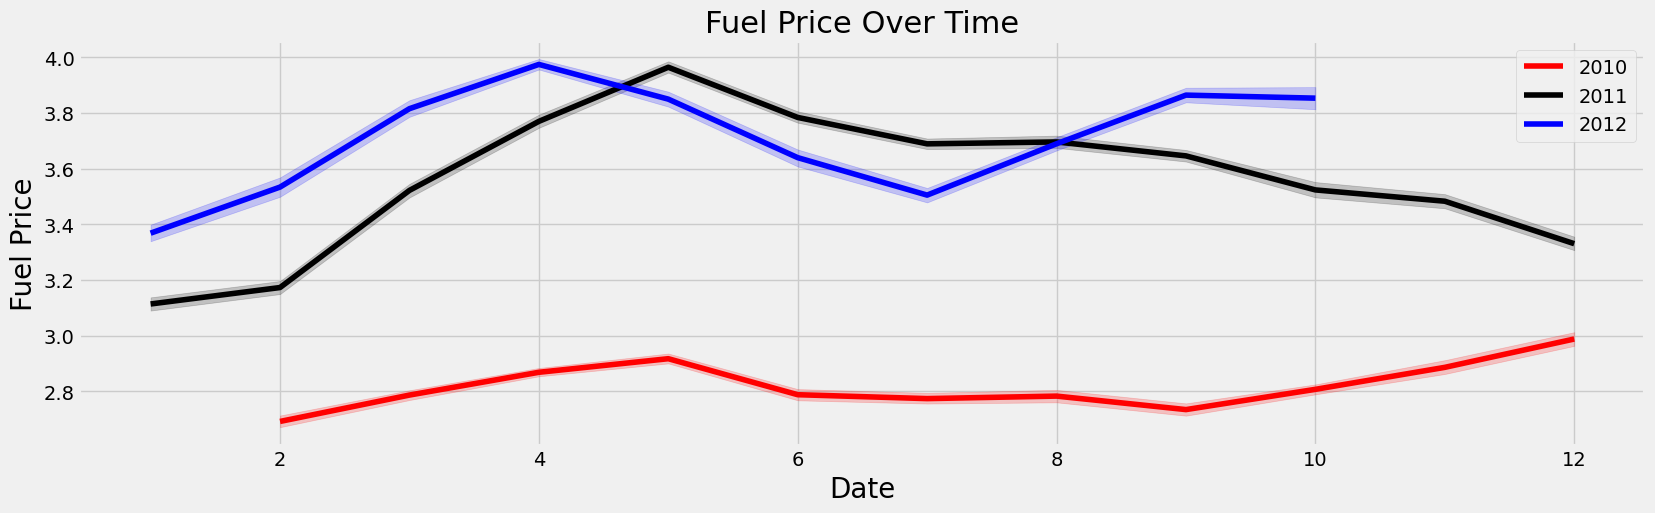

In [61]:
plt.figure(figsize = (18, 5))
for i, year in enumerate(years):
    sns.lineplot(data = data[data['year'] == int(year)],
                 x = 'month',
                 y = 'fuel_price',
                 estimator = np.mean,
                 color = colors[i],
                 label = year)

# Add labels and title
plt.title(f'Fuel Price Over Time', size = 22)
plt.xlabel('Date', size = 20)
plt.ylabel('Fuel Price', size = 20)

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [62]:
# Let's calculate the Pearson Correlation Coefficient and P-value of 'fuel_price' and 'weekly_sales':
pearson_coef, p_value = stats.pearsonr(data['fuel_price'], data['weekly_sales'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is 0.00946378631447513  with a P-value of P = 0.44782874894858105


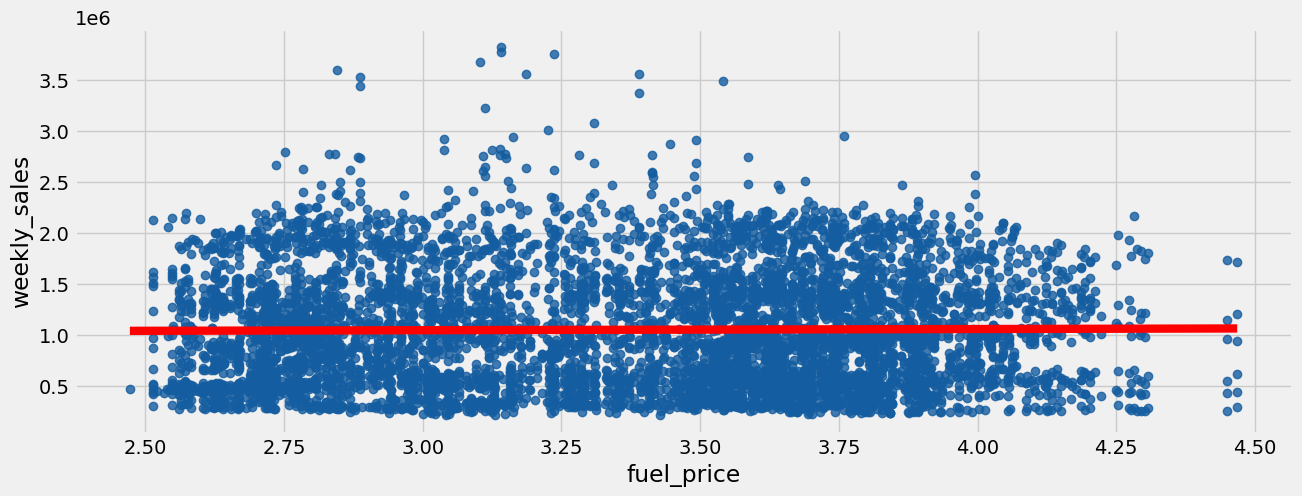

In [63]:
plt.figure(figsize = (14, 5))
sns.regplot(data = data, x = 'fuel_price', y = 'weekly_sales', color = '#145DA0', line_kws = {'color': 'red'})
plt.show()


In [64]:
# Let's calculate the Pearson Correlation Coefficient and P-value of 'unemployment' and 'weekly_sales':
pearson_coef, p_value = stats.pearsonr(data['unemployment'], data['weekly_sales'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.10617608965795415  with a P-value of P = 1.3448365210234661e-17


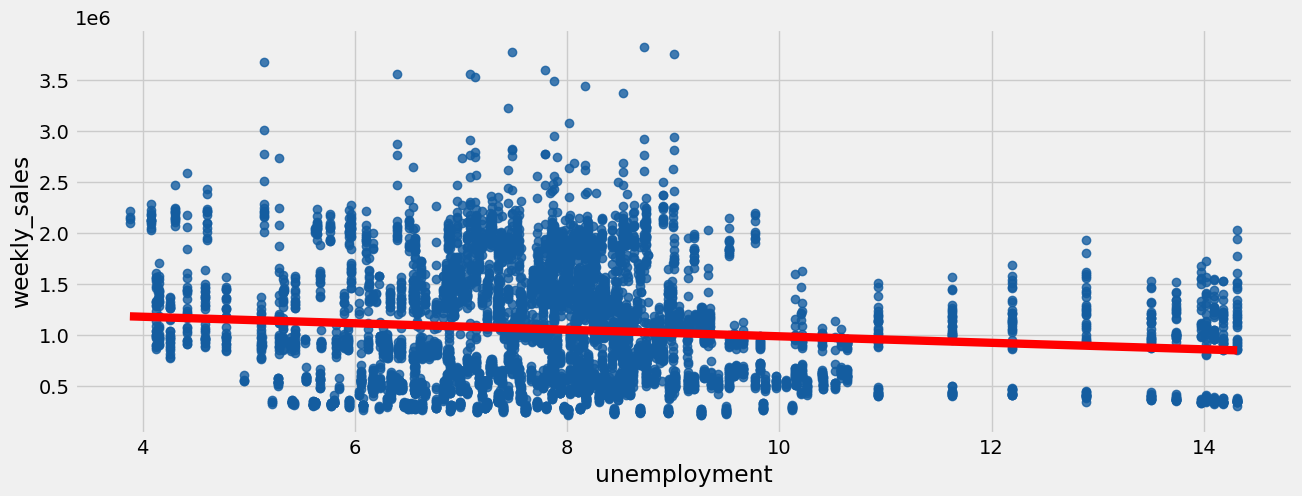

In [65]:
plt.figure(figsize = (14, 5))
sns.regplot(data = data, x = 'unemployment', y = 'weekly_sales', color = '#145DA0', line_kws = {'color': 'red'})
plt.show()

In [66]:
# Let's calculate the Pearson Correlation Coefficient and P-value of cpi' and 'weekly_sales':
pearson_coef, p_value = stats.pearsonr(data['cpi'], data['weekly_sales'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.07263416204017621  with a P-value of P = 5.438292612176736e-09


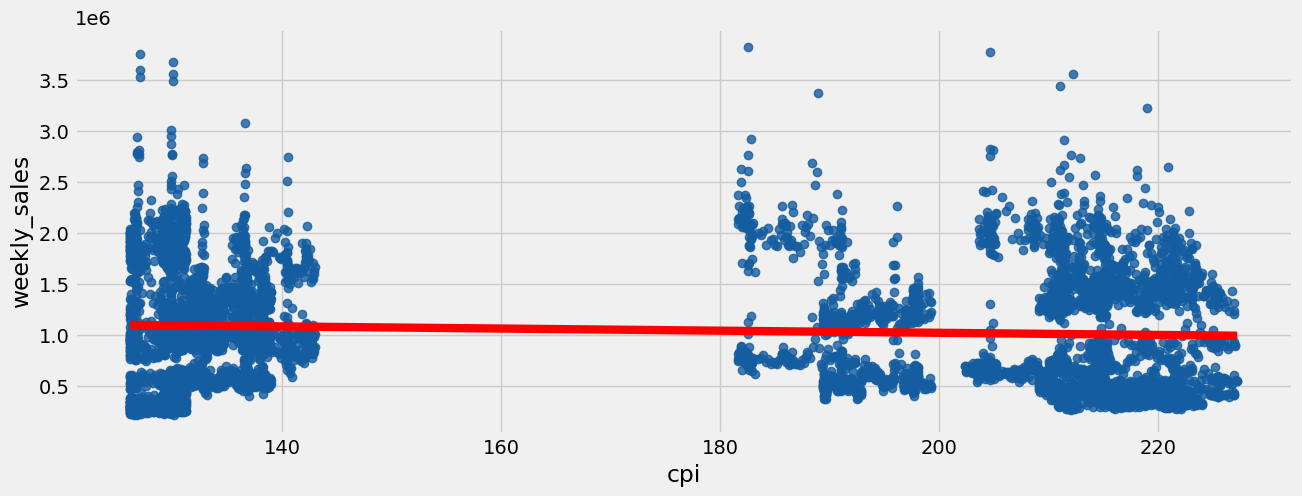

In [67]:
plt.figure(figsize = (14, 5))
sns.regplot(data = data, x = 'cpi', y = 'weekly_sales', color = '#145DA0', line_kws = {'color': 'red'})
plt.show()

In [68]:
# Let's calculate the Pearson Correlation Coefficient and P-value of temperature' and 'weekly_sales':
pearson_coef, p_value = stats.pearsonr(data['temperature'], data['weekly_sales'])
print("The Pearson Correlation Coefficient is", pearson_coef, " with a P-value of P =", p_value)

The Pearson Correlation Coefficient is -0.06381001317946959  with a P-value of P = 3.0076476258332254e-07


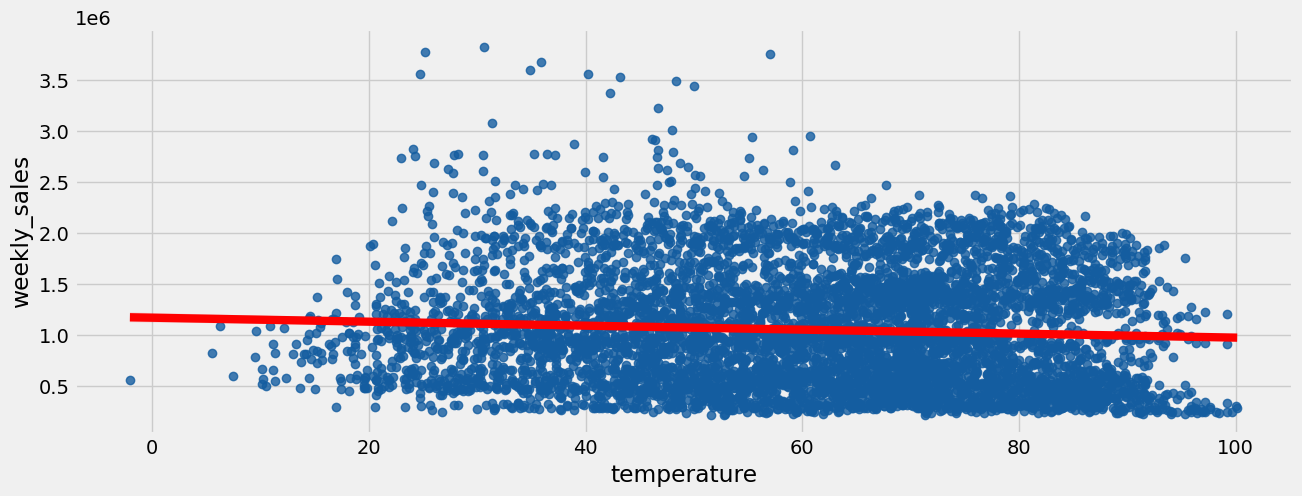

In [69]:
plt.figure(figsize = (14, 5))
sns.regplot(data = data, x = 'temperature', y = 'weekly_sales', color = '#145DA0', line_kws = {'color': 'red'})
plt.show()

In [70]:
# Correlations with weekly sales
corr = data[['weekly_sales', 'temperature', 'fuel_price', 'cpi', 'unemployment']].corr()['weekly_sales'].sort_values(ascending = False)
corr = corr.to_frame()
corr.style.background_gradient(cmap="RdYlBu")

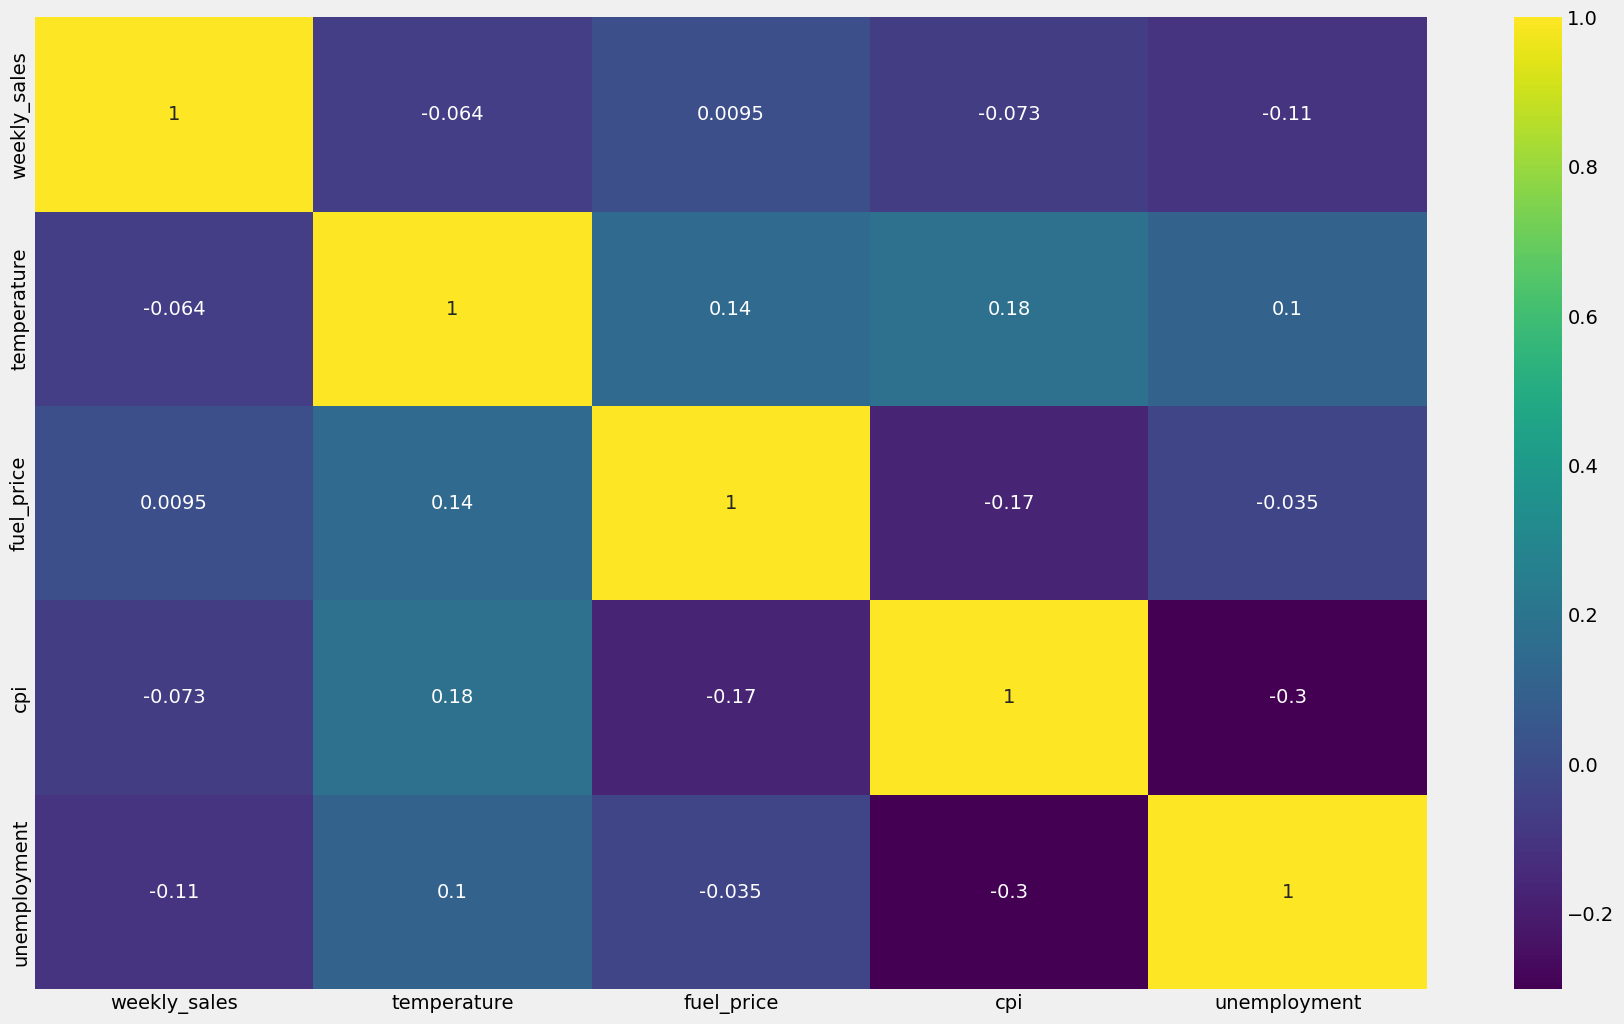

In [71]:
# Heatmap to explain the correlation between the features
plt.figure(figsize = (20, 12))
sns.heatmap(data[['weekly_sales', 'temperature', 'fuel_price', 'cpi', 'unemployment']].corr(), annot = True, cmap='viridis')
plt.show()

In [72]:
data_copy = data.copy()

In [73]:
data_copy.drop(['date', 'year', 'quarter', 'month', 'day_of_week'], axis = 1, inplace = True)

In [74]:
# Check the data types
data_copy.dtypes

store             int64
weekly_sales    float64
is_holiday        int64
temperature     float64
fuel_price      float64
cpi             float64
unemployment    float64
season           object
month_name       object
week              int32
dtype: object

In [75]:
# let's handle store and holiday columns as categorical features, so we should convert them into categories (objects).bb
data_copy['store'] = data_copy['store'].astype('object')
data_copy['is_holiday'] = data_copy['is_holiday'].astype('object')
data_copy['week'] = data_copy['week'].astype('object')

In [76]:
# Check the data types after convert
data_copy.dtypes

store            object
weekly_sales    float64
is_holiday       object
temperature     float64
fuel_price      float64
cpi             float64
unemployment    float64
season           object
month_name       object
week             object
dtype: object

0 fuel_price
1 temperature
2 cpi
3 unemployment


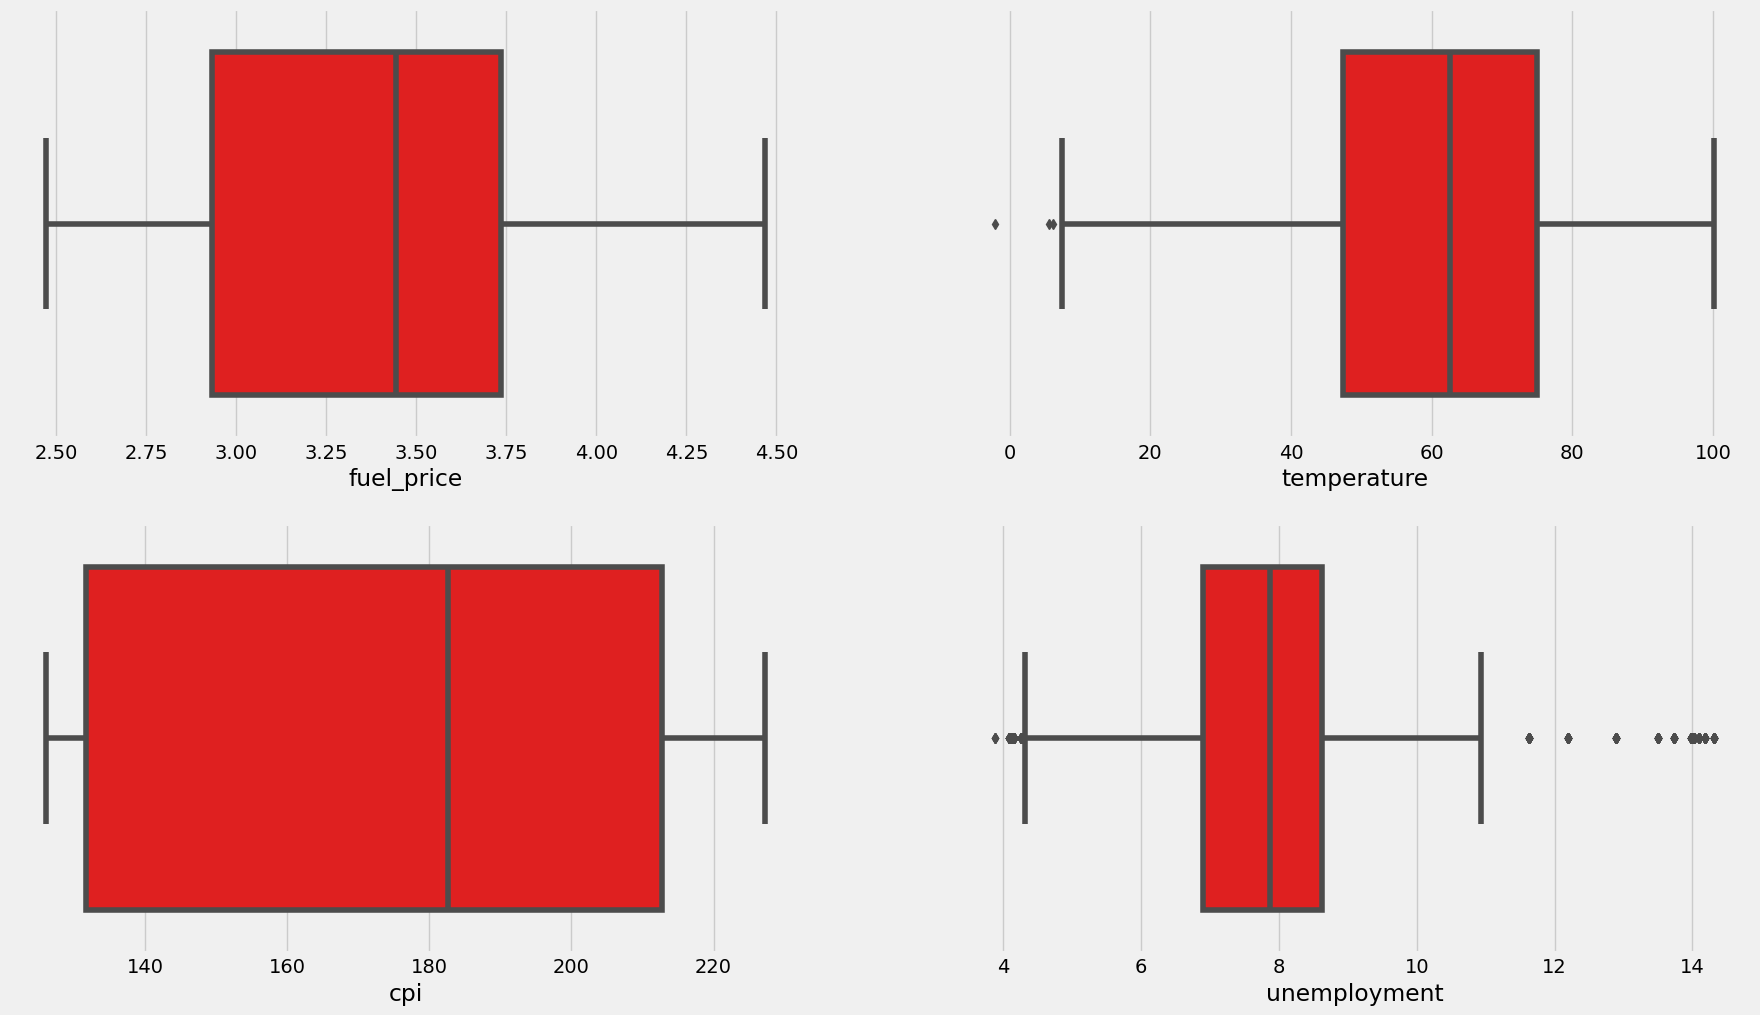

Number of data rows:  6435


In [77]:
cols = ['fuel_price', 'temperature', 'cpi', 'unemployment']
plt.figure(figsize=(20,18))
for i,col in enumerate(cols):
    print(i, col)
    plt.subplot(3,2,i+1)
    sns.boxplot(data_copy, x = col, color = 'red')
plt.show()

print('Number of data rows: ', data_copy.shape[0])

In [78]:
# Remove outliers from the temperature column
data_copy.drop(data_copy[data_copy['temperature'] < 7].index, axis = 0, inplace = True)

In [79]:
# Remove outliers from the unemployment column
data_copy.drop(data_copy[data_copy['unemployment'] < 4.4].index, axis = 0, inplace = True)
data_copy.drop(data_copy[data_copy['unemployment'] > 11].index, axis = 0, inplace = True)

0 temperature
1 fuel_price
2 cpi
3 unemployment


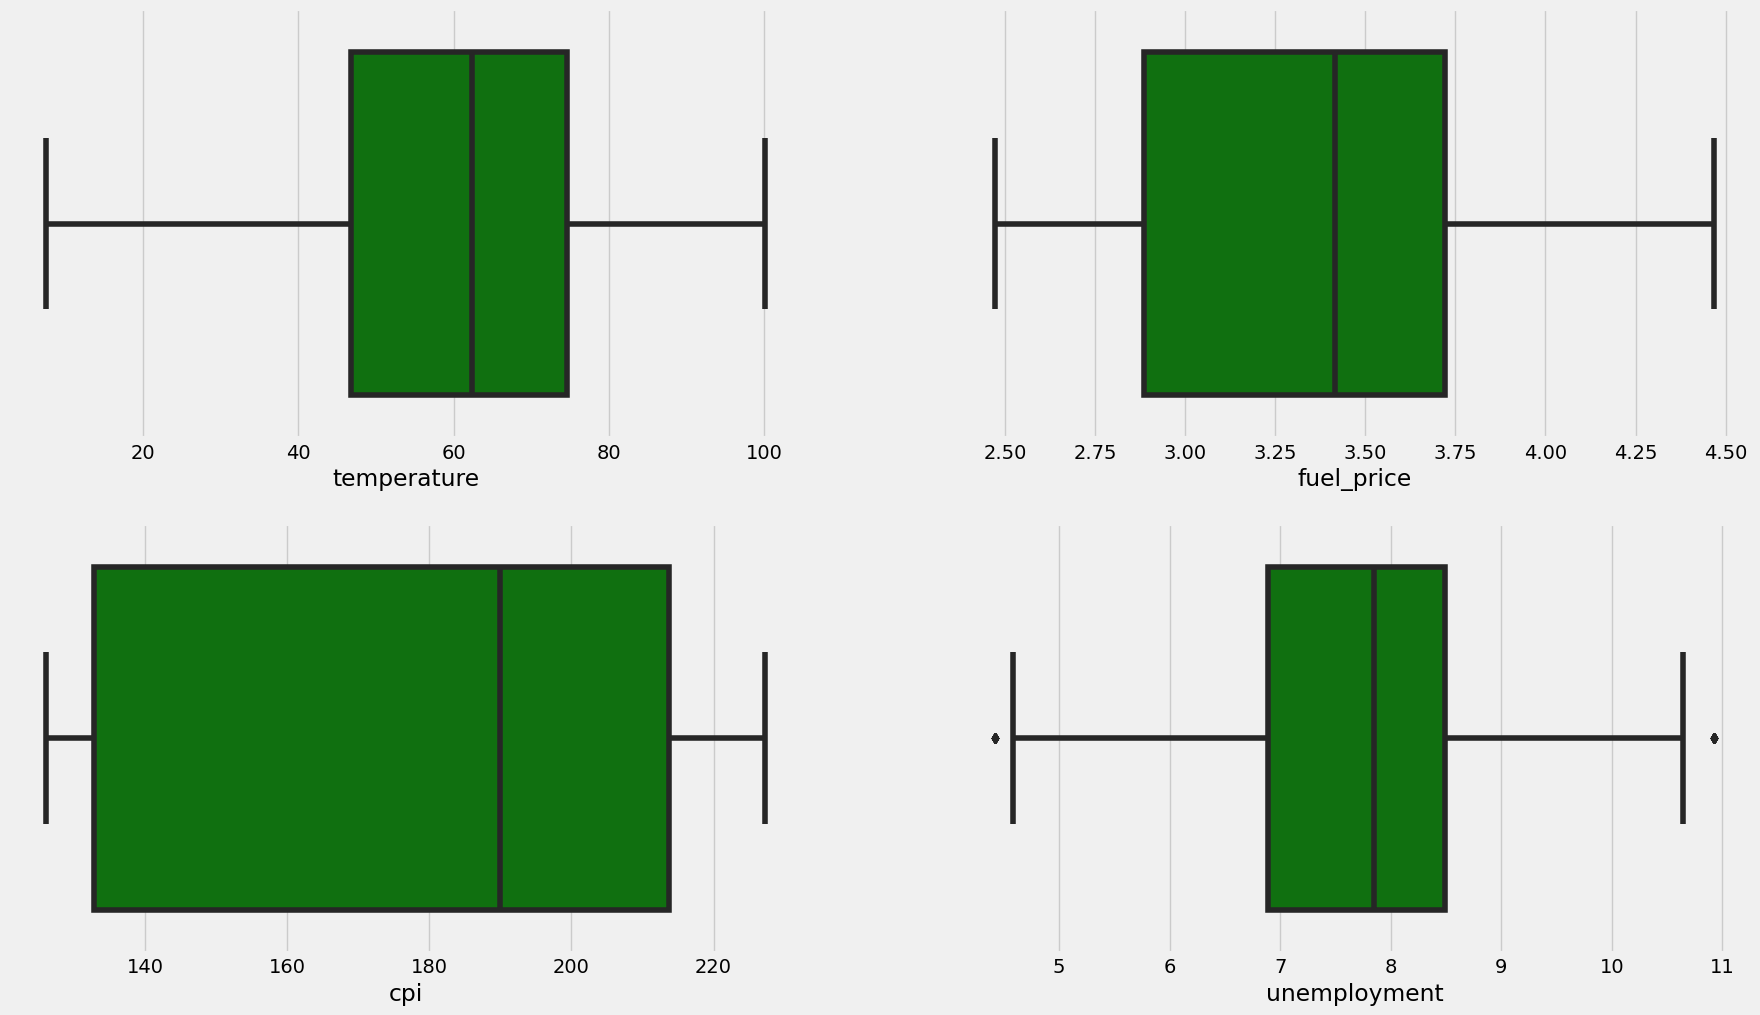

Number of data rows:  5938


In [80]:
cols = ['temperature', 'fuel_price', 'cpi', 'unemployment']
plt.figure(figsize=(20,18))
for i, col in enumerate(cols):
    print(i, col)
    plt.subplot(3,2,i+1)
    sns.boxplot(data_copy, x = col, color = 'g')
plt.show()

print('Number of data rows: ', data_copy.shape[0])

In [82]:
X = data_copy.drop('weekly_sales', axis = 1)
y = data_copy['weekly_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [83]:
print('Shape of data      : ', X.shape)
print('Shape of train data: ', X_train.shape)
print('Shape of test data : ', X_test.shape)

Shape of data      :  (5938, 9)
Shape of train data:  (4750, 9)
Shape of test data :  (1188, 9)


In [84]:
# Splitting the data into Numerical Features and Categorical Features
num_features = data_copy.select_dtypes('number').columns.to_list()
num_features.remove('weekly_sales')

cat_features = data_copy.select_dtypes('object').columns.to_list()

print(f'Numerical Features : {num_features}')
print(f'Categorical Features: {cat_features}')

Numerical Features : ['temperature', 'fuel_price', 'cpi', 'unemployment']
Categorical Features: ['store', 'is_holiday', 'season', 'month_name', 'week']


In [85]:
# data transformation pipeline
preprocessor = ColumnTransformer([
                                  ('num_features', StandardScaler(), num_features),
                                  ('cat_features', BinaryEncoder(), cat_features),
                                ])

# Fitting the training data
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num_features', StandardScaler(),
                                 ['temperature', 'fuel_price', 'cpi',
                                  'unemployment']),
                                ('cat_features', BinaryEncoder(),
                                 ['store', 'is_holiday', 'season', 'month_name',
                                  'week'])])

In [86]:
# Transform the training data
X_train_transformed = preprocessor.transform(X_train)

# Transform the testing data
X_test_transformed = preprocessor.transform(X_test)

In [87]:
def model_evaluation(estimator, Training_Testing, X, y):

    ''' This function is used to evaluate the model through RMSE and R2'''

    # Y predict of X train or X test
    predict_data = estimator.predict(X)

    print(f'{Training_Testing} Accuracy: \n')
    print(f'-> Root Mean Squared Error: {round(np.sqrt(mean_squared_error(y, predict_data)), 2)}')
    print(f'-> R-Squere score Training: {round(r2_score(y, predict_data) * 100, 2)} % \n')

In [88]:
def Distribution_Plot(estimator, Training_Testing, X, y, Title):

    """This function is used to perform some model evaluation using training and testing data \
    by plotting the distribution of the actual and predicted values of the training or testing data."""

    # Y predict of X train or X test
    yhat = estimator.predict(X)

    plt.figure(figsize=(14, 6))
    ax1 = sns.distplot(y, hist = False, color = "b", label = f'Actual Values ({Training_Testing})')
    ax2 = sns.distplot(yhat, hist = False, color = "r", label = f'Predicted Values ({Training_Testing})', ax = ax1)
    plt.title(Title, size = 18)
    plt.legend()
    plt.show()

In [89]:
def cross_validation_score(estimator, X_train, y_train, score = 'r2', n = 5):

    '''This function is to validate the model'''


    validate = cross_val_score(estimator, X_train, y_train, scoring = score, cv = n)

    print(f'Cross Validation Scores: {validate} \n')
    print(f'Mean of Scores: {round(validate.mean() * 100, 2)} % \n')
    print(f'Standard Deviation of Scores: {validate.std()}')

In [90]:
def hyperparameter_tunning(estimator, X_train, y_train, param_grid, score = 'r2', n = 5):

    '''This function is used to find the best set of hyperparameters for the model to optimize its performance'''


    # Perform grid search
    grid_search = GridSearchCV(estimator = estimator,
                               param_grid = param_grid,
                               scoring = score,
                               cv = n)

    # Fit the data
    grid_search.fit(X_train,y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Print the best parameters and score
    print(f'Best parameters: {best_params} \n')
    print(f'Best score: {best_score}')

    # best estimator
    best_estimator = grid_search.best_estimator_

    return best_estimator

In [91]:
# Linear Regression Model
LR = LinearRegression()

# Fitting the data
LR.fit(X_train_transformed, y_train)

LinearRegression()

In [92]:
# Training Accuracy
model_evaluation(LR, 'Training', X_train_transformed, y_train)

Training Accuracy: 

-> Root Mean Squared Error: 522051.03
-> R-Squere score Training: 16.11 % 



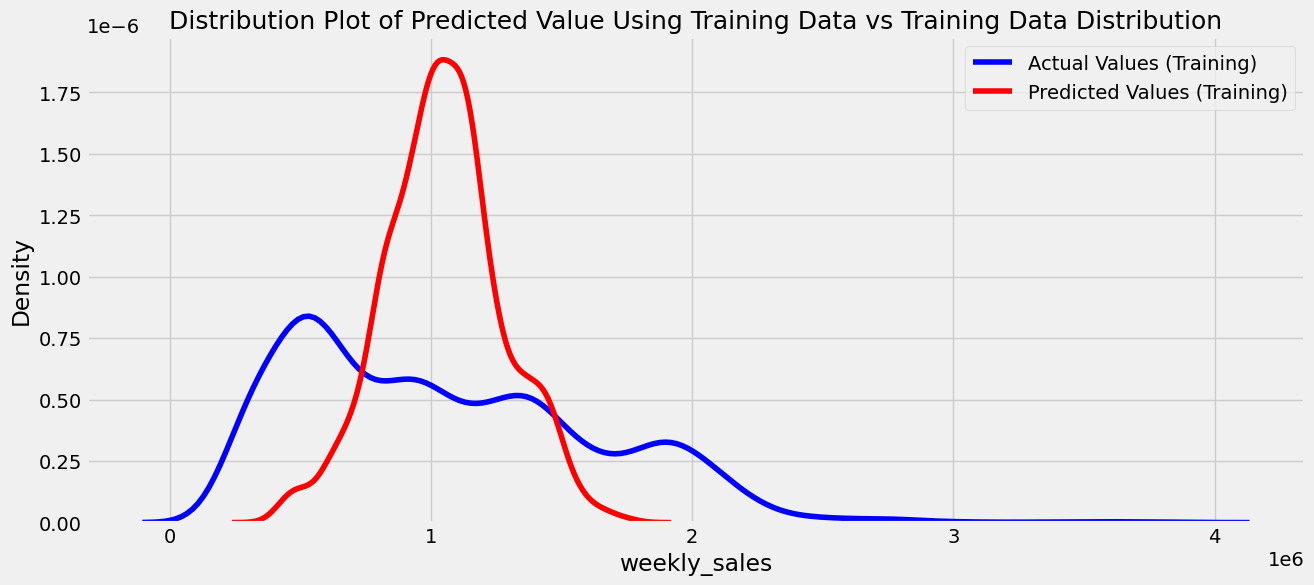

In [93]:
# Figure 1: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(LR, 'Training', X_train_transformed, y_train, Title)

In [98]:
# Polynomial Regression Model
LR_pipe = Pipeline([('poly_feat', PolynomialFeatures()),
                    ('lin_reg', LinearRegression())])

# Define the parameter grid to search
param_grid = {'poly_feat__degree': [2, 3, 4]}

best_estimator = hyperparameter_tunning(LR_pipe, X_train_transformed, y_train, param_grid, score = 'r2', n = 5)

Best parameters: {'poly_feat__degree': 3} 

Best score: 0.9614541190087665


In [95]:
# Linear Regression Model after tuning
poly_reg = best_estimator

In [96]:
# Linear Regression Model after tuning
poly_reg = best_estimator

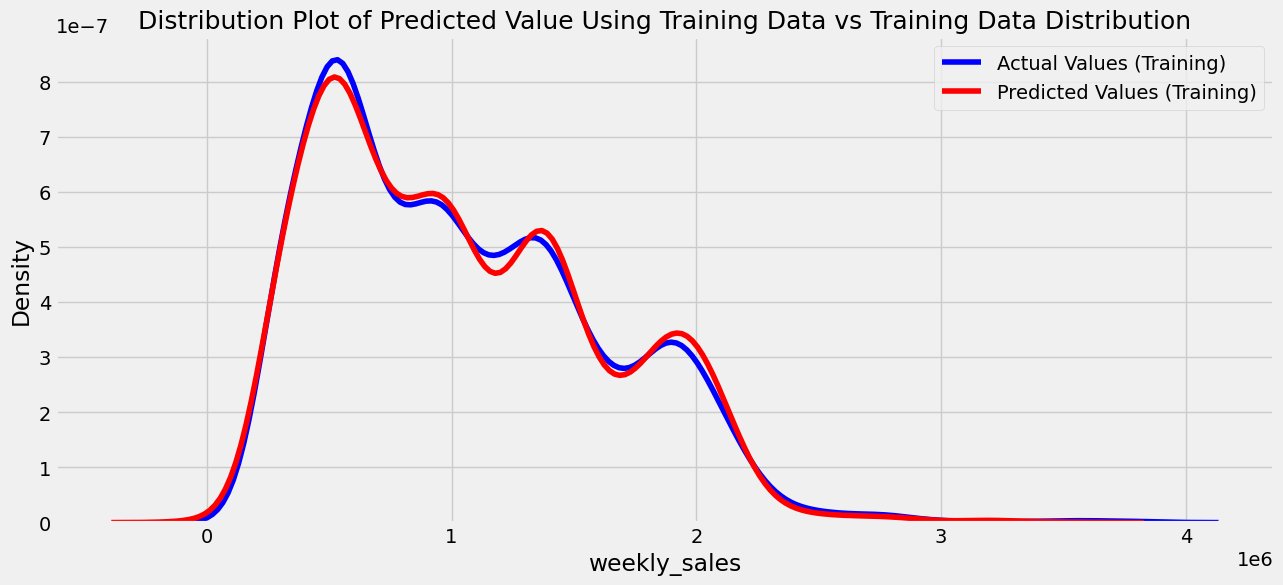

In [97]:
# Figure 2: Plot of predicted values using the training data compared to the actual values of the training data.
Title = 'Distribution Plot of Predicted Value Using Training Data vs Training Data Distribution'
Distribution_Plot(poly_reg, 'Training', X_train_transformed, y_train, Title)

In [99]:
cross_validation_score(poly_reg, X_train_transformed, y_train)

Cross Validation Scores: [0.96025197 0.96210502 0.95977097 0.96766745 0.95747518] 

Mean of Scores: 96.15 % 

Standard Deviation of Scores: 0.0034391639045420943


In [100]:
# Testing Accuracy
model_evaluation(poly_reg, 'Testing', X_test_transformed, y_test)

Testing Accuracy: 

-> Root Mean Squared Error: 101681.5
-> R-Squere score Training: 96.84 % 



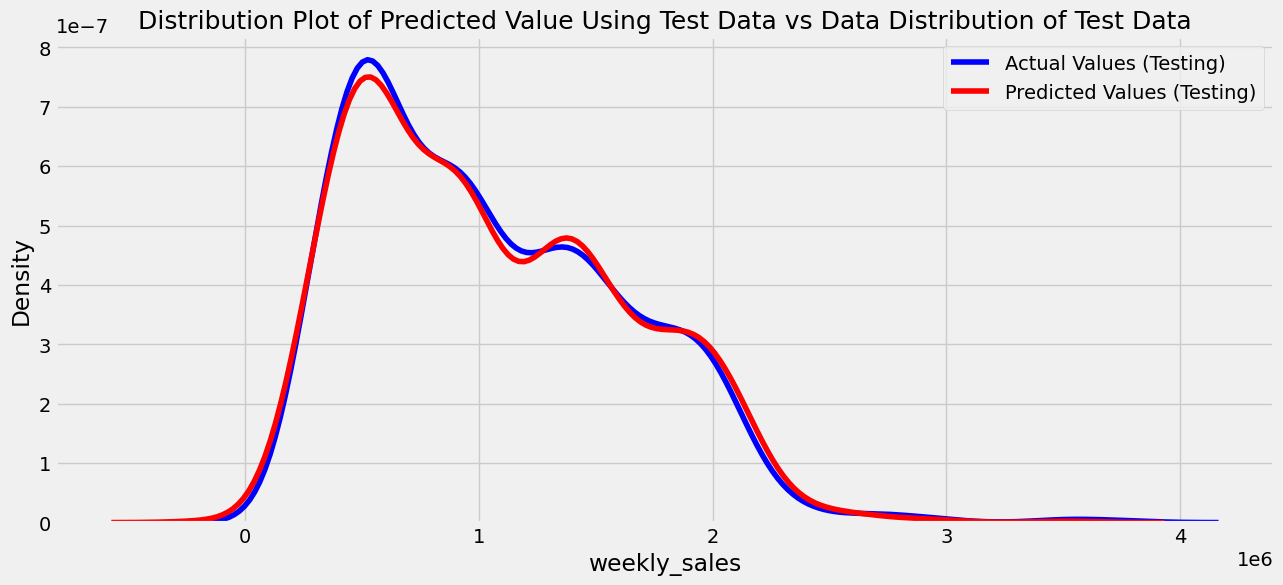

In [101]:
# Figure 3: Plot of predicted value using the test data compared to the actual values of the test data.
Title='Distribution Plot of Predicted Value Using Test Data vs Data Distribution of Test Data'
Distribution_Plot(poly_reg, 'Testing', X_test_transformed, y_test, Title)